In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Collect Data

In [54]:
tickers_names = {"SHEL": "Shell",
                 "XOM": "ExxonMobil",
                 "BP": "BP",
                 "CVX": "Chevron"}

oil_tickers_names = {'CL=F':'Crude Oil',
                     'NG=F':'Natural Gas'}

def FetchStockData(ticker_symbol, company_name):
    ticker = yf.Ticker(ticker_symbol)
    today = datetime.date.today().strftime('%Y-%m-%d')
    data = ticker.history(start="2021-01-01", end=today)
    
    # Reset the index and keep 'Date' as a column
    data.reset_index(inplace=True)
    
    # Ensure the 'Date' column is in the correct format
    if pd.api.types.is_datetime64_any_dtype(data['Date']):
        data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
    
    # Drop unnecessary columns
    data.drop(columns=['Dividends', 'Stock Splits'], inplace=True, errors='ignore')
    
    # Add additional columns for ticker and commodity
    data['ticker'] = ticker_symbol  
    data['company'] = company_name  
    
    # Convert all column names to lowercase for consistency
    data.columns = [col.lower() for col in data.columns]
    
    # Reorder columns to place 'ticker', 'commodity', and 'date' at the beginning
    data = data[['ticker', 'company', 'date'] + [col for col in data.columns if col not in ['ticker', 'company', 'date']]]
    data['date'] = pd.to_datetime(data['date'])

    return data



# 2. Loop over each symbol and append data to a DataFrame
all_data = []
for symbol, name in tickers_names.items():
    all_data.append(FetchStockData(symbol, name))
for symbol, name in oil_tickers_names.items():
    all_data.append(FetchStockData(symbol, name))
# Concatenate all the individual datasets into one
stock_data = pd.concat(all_data, ignore_index=True)
stock_data.to_csv('data/stock_data.csv', index = False)


# Inspect Data

## General

In [55]:
print("Energy Stock Prices Dataset Info:")
print(stock_data.info())

Energy Stock Prices Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6489 entries, 0 to 6488
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ticker   6489 non-null   object        
 1   company  6489 non-null   object        
 2   date     6489 non-null   datetime64[ns]
 3   open     6489 non-null   float64       
 4   high     6489 non-null   float64       
 5   low      6489 non-null   float64       
 6   close    6489 non-null   float64       
 7   volume   6489 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 405.7+ KB
None


In [56]:
print("Energy Stock Prices Dataset Description:")
print(stock_data.describe())

Energy Stock Prices Dataset Description:
                                date         open         high          low  \
count                           6489  6489.000000  6489.000000  6489.000000   
mean   2023-02-25 20:42:29.791955456    64.348394    65.089132    63.580378   
min              2021-01-04 00:00:00     1.533000     1.628000     1.481000   
25%              2022-01-28 00:00:00    30.184014    30.484031    29.989065   
50%              2023-02-27 00:00:00    61.600831    62.259998    60.935428   
75%              2024-03-25 00:00:00    93.965542    95.438618    92.709974   
max              2025-04-23 00:00:00   169.405654   171.723297   168.554636   
std                              NaN    45.185099    45.656211    44.684844   

             close        volume  
count  6489.000000  6.489000e+03  
mean     64.341434  7.704820e+06  
min       1.575000  0.000000e+00  
25%      30.282249  3.317090e+05  
50%      61.560001  5.925100e+06  
75%      94.123505  1.134470e+07  
ma

In [57]:
print("The Number of Instances for Each Company:")
print(stock_data['company'].value_counts())

The Number of Instances for Each Company:
company
Natural Gas    1083
Crude Oil      1082
ExxonMobil     1081
Shell          1081
Chevron        1081
BP             1081
Name: count, dtype: int64


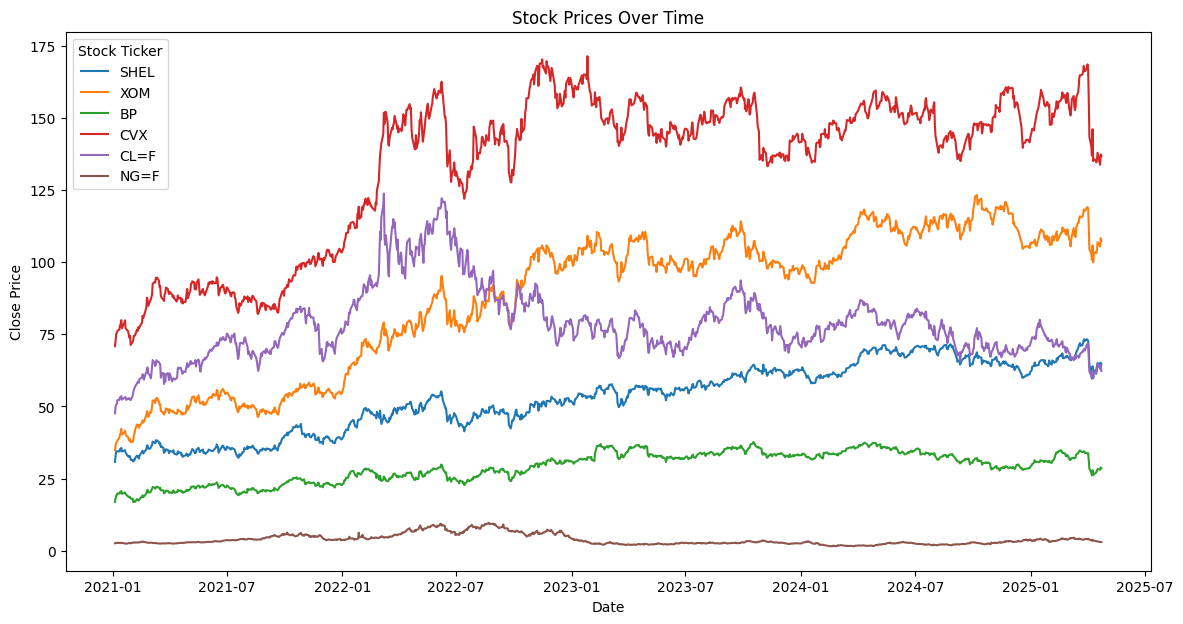

In [58]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data, x='date', y='close', hue='ticker')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title='Stock Ticker')
plt.savefig("plots/stock_prices_over_time.png", dpi=300, bbox_inches='tight') 
plt.show()

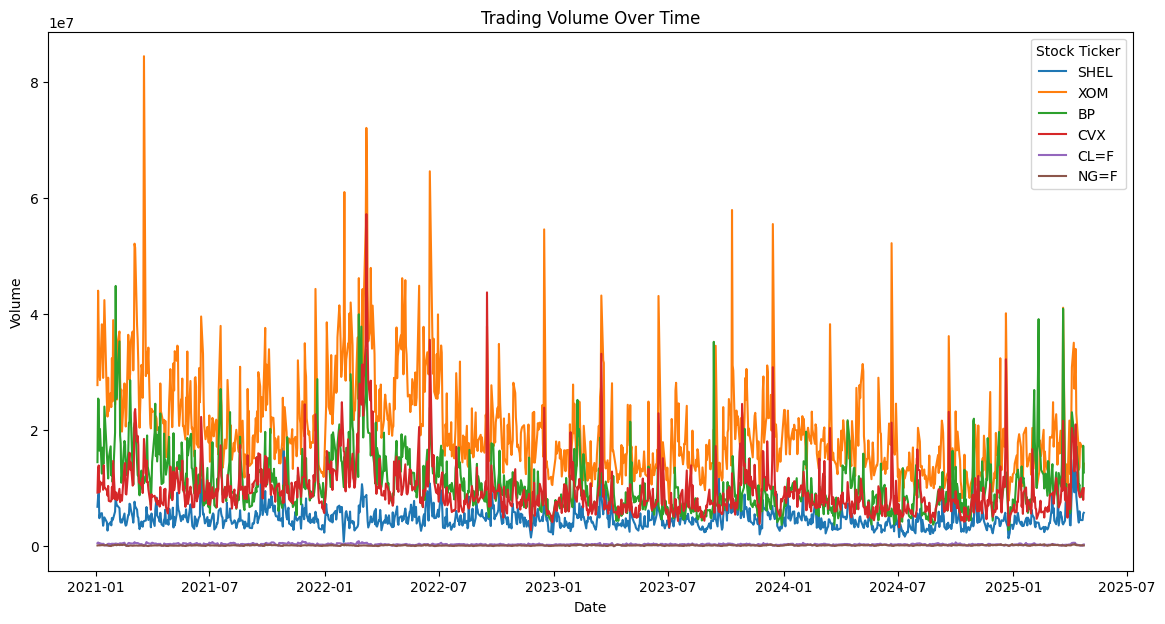

In [59]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data, x='date', y='volume', hue='ticker')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(title='Stock Ticker')
plt.savefig("plots/trading_volume_over_time.png", dpi=300, bbox_inches='tight') 
plt.show()

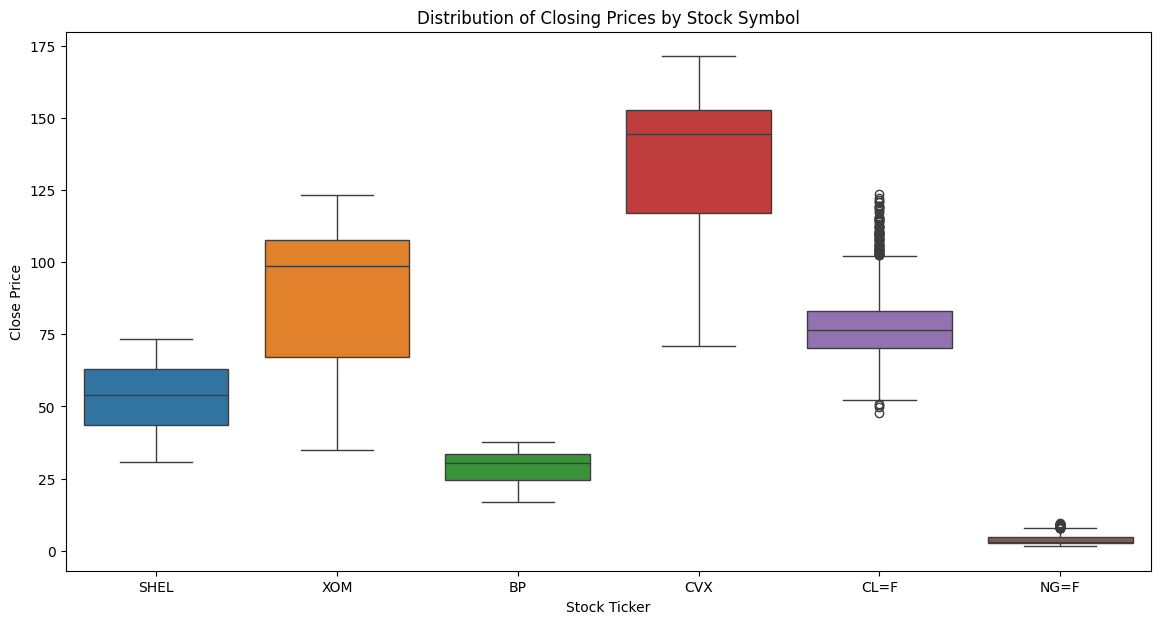

In [60]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=stock_data, x='ticker', y='close', hue='ticker')
plt.title('Distribution of Closing Prices by Stock Symbol')
plt.xlabel('Stock Ticker')
plt.ylabel('Close Price')
plt.savefig("plots/distribution_of_closing_prices_by_stock_symbol.png", dpi=300, bbox_inches='tight') 
plt.show()

In [61]:
# pivot_table = stock_data.pivot(index='date', columns='ticker', values='close')
# pivot_table

pivot_table = stock_data.reset_index().pivot(index='date', columns='ticker', values='close')
pivot_table


ticker             BP       CL=F         CVX   NG=F       SHEL         XOM
date                                                                      
2021-01-04  16.946373  47.619999   70.881584  2.581  30.810043   34.851482
2021-01-05  18.207386  49.930000   72.797752  2.702  32.930740   36.531071
2021-01-06  19.045347  50.630001   75.140694  2.716  34.452862   37.463245
2021-01-07  19.452124  50.830002   75.492119  2.729  34.495609   37.757168
2021-01-08  19.850769  52.240002   76.211716  2.700  34.410103   38.177067
...               ...        ...         ...    ...        ...         ...
2025-04-16  27.660000  62.470001  135.360001  3.247  64.029999  104.190002
2025-04-17  28.320000  64.680000  137.869995  3.245  65.040001  106.919998
2025-04-21  28.080000  63.080002  133.729996  3.016  64.650002  105.349998
2025-04-22  28.870001  64.309998  137.300003  3.007  65.169998  108.300003
2025-04-23  28.600000  62.270000  136.679993  3.022  64.510002  107.370003

[1083 rows x 6 columns]

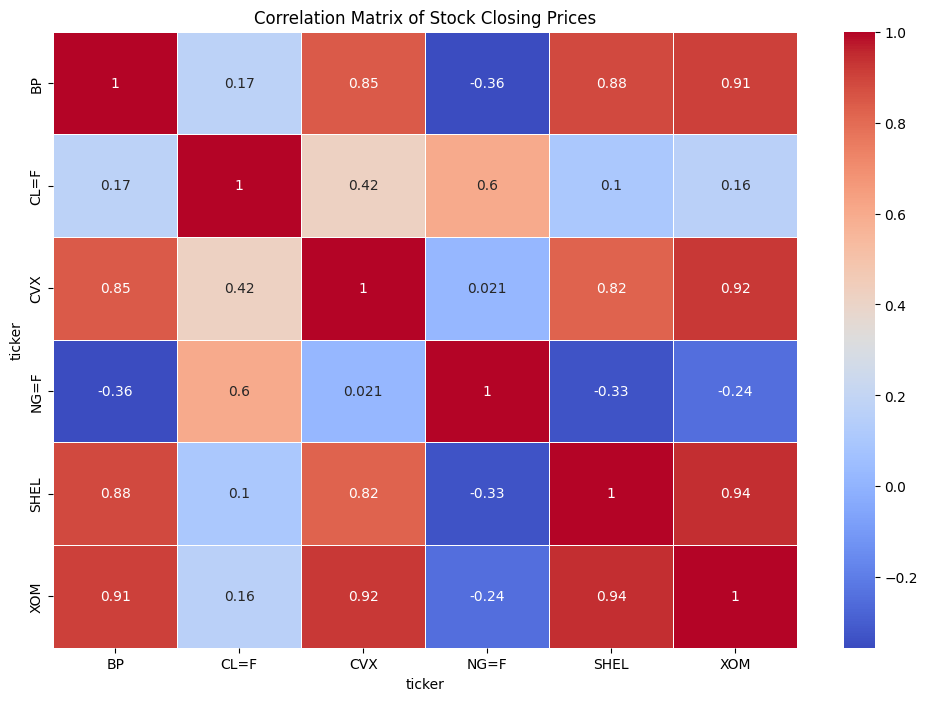

In [62]:
correlation_matrix = pivot_table.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Stock Closing Prices')
plt.savefig("plots/correlation_matrix_of_stock_closing_prices.png", dpi=300, bbox_inches='tight') 
plt.show()

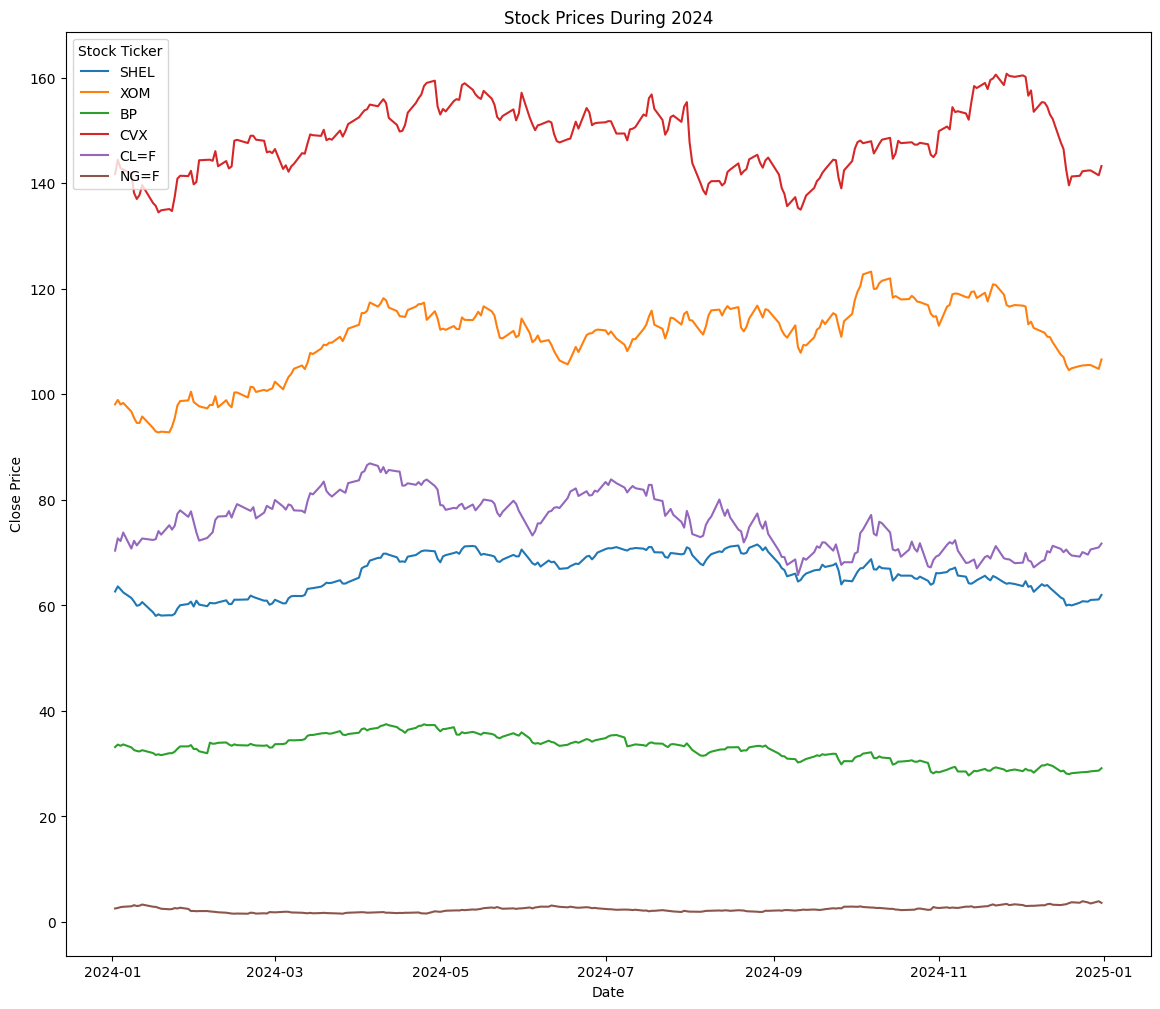

In [63]:
stock_data_2024 = stock_data.reset_index()[(stock_data['date'] >= '2024-01-01') & (stock_data['date'] <= '2024-12-31')]

plt.figure(figsize= (14, 12))
sns.lineplot(data = stock_data_2024, x = 'date', y = 'close', hue = 'ticker')
plt.title('Stock Prices During 2024')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title = 'Stock Ticker')
plt.savefig("plots/stock_prices_during_2024.png", dpi=300, bbox_inches='tight') 
plt.show()

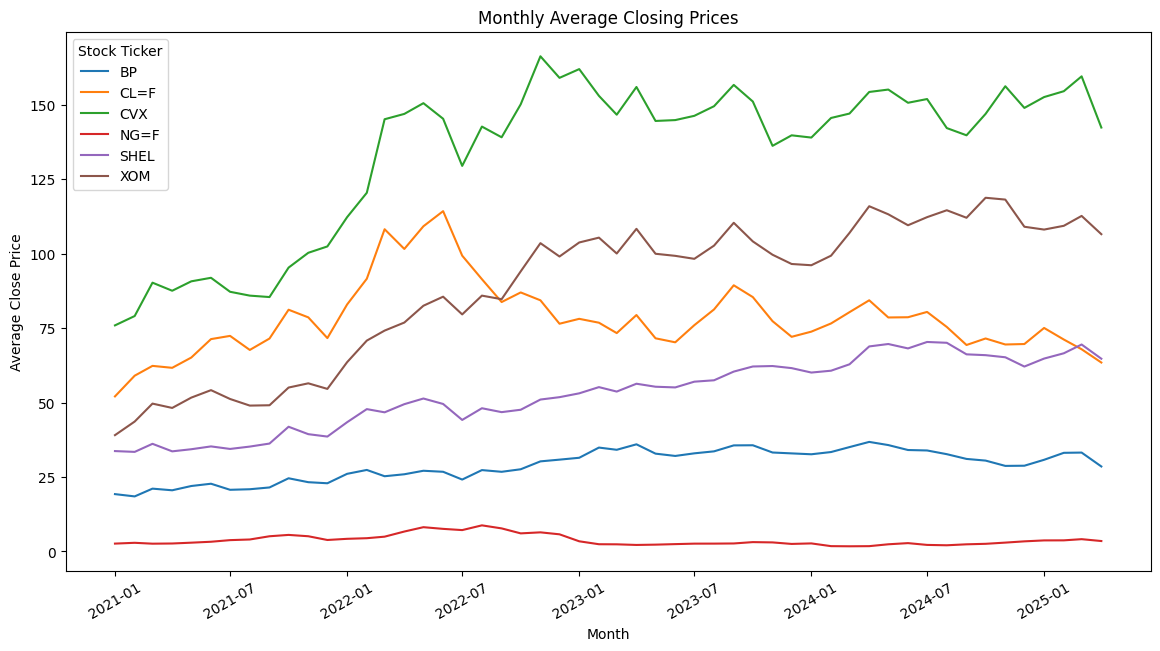

In [64]:
stock_data['month'] = stock_data['date'].dt.to_period('M').dt.to_timestamp()
monthly_avg_prices = stock_data.groupby(['month', 'ticker']).mean(numeric_only=True).reset_index()

plt.figure(figsize = (14, 7))
sns.lineplot(data = monthly_avg_prices, x = 'month', y = 'close', hue = 'ticker')
plt.title('Monthly Average Closing Prices')
plt.xlabel('Month')
plt.ylabel('Average Close Price')
plt.xticks(rotation = 30)
plt.legend(title = 'Stock Ticker')
plt.savefig("plots/monthly_average_closing_prices.png", dpi=300, bbox_inches='tight') 
plt.show()

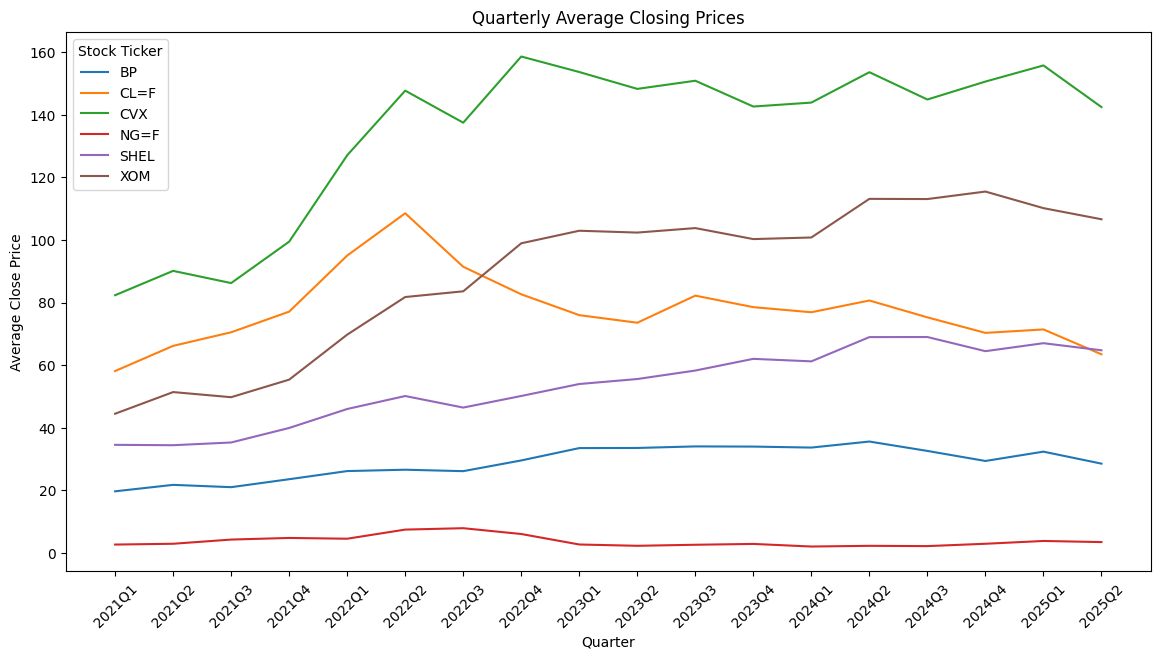

In [65]:
stock_data['quarter'] = stock_data['date'].dt.to_period('Q')
quarterly_avg_prices = stock_data.groupby(['quarter', 'ticker']).mean(numeric_only=True).reset_index()
quarterly_avg_prices['quarter'] = quarterly_avg_prices['quarter'].astype(str)

plt.figure(figsize = (14, 7))
sns.lineplot(data = quarterly_avg_prices, x = 'quarter', y = 'close', hue = 'ticker')
plt.title('Quarterly Average Closing Prices')
plt.xlabel('Quarter')
plt.ylabel('Average Close Price')
plt.xticks(rotation = 45)
plt.legend(title = 'Stock Ticker')
plt.savefig("plots/quarterly_average_closing_prices.png", dpi=300, bbox_inches='tight') 
plt.show()

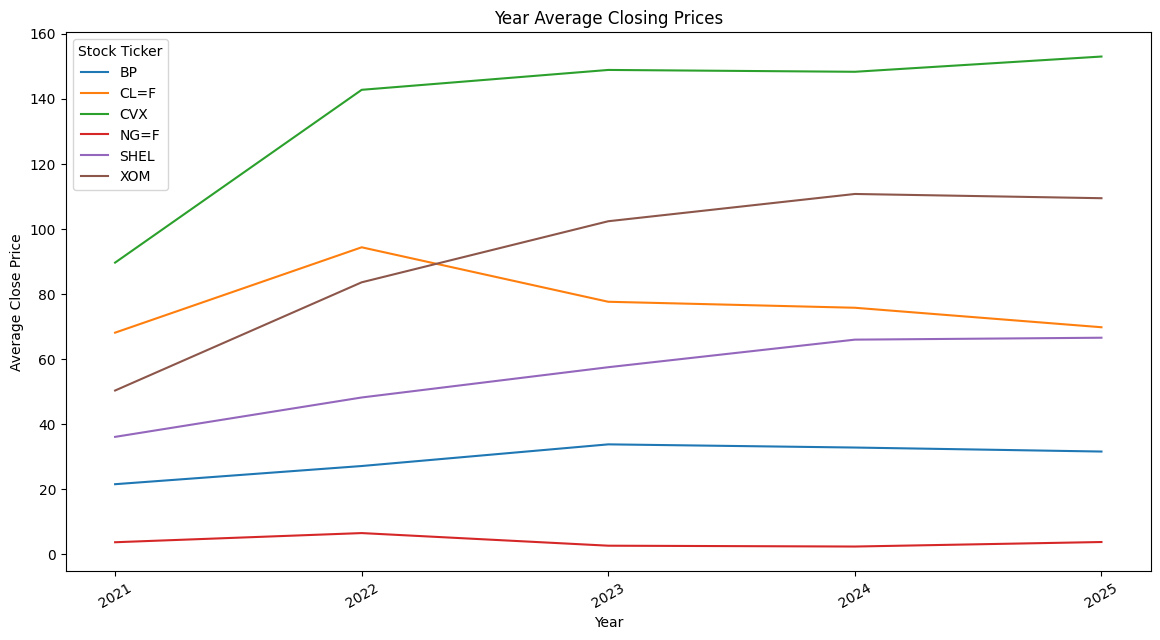

In [66]:
stock_data['year'] = stock_data['date'].dt.year
yearly_avg_prices = stock_data.groupby(['year', 'ticker']).mean(numeric_only=True).reset_index()
yearly_avg_prices['year'] = yearly_avg_prices['year'].astype(int)

plt.figure(figsize = (14, 7))
sns.lineplot(data = yearly_avg_prices, x = 'year', y = 'close', hue = 'ticker')
plt.title('Year Average Closing Prices')
plt.xlabel('Year')
plt.ylabel('Average Close Price')
plt.xticks(ticks=yearly_avg_prices['year'].unique(), rotation=30)
plt.legend(title = 'Stock Ticker')
plt.savefig("plots/year_average_closing_prices.png", dpi=300, bbox_inches='tight') 
plt.show()

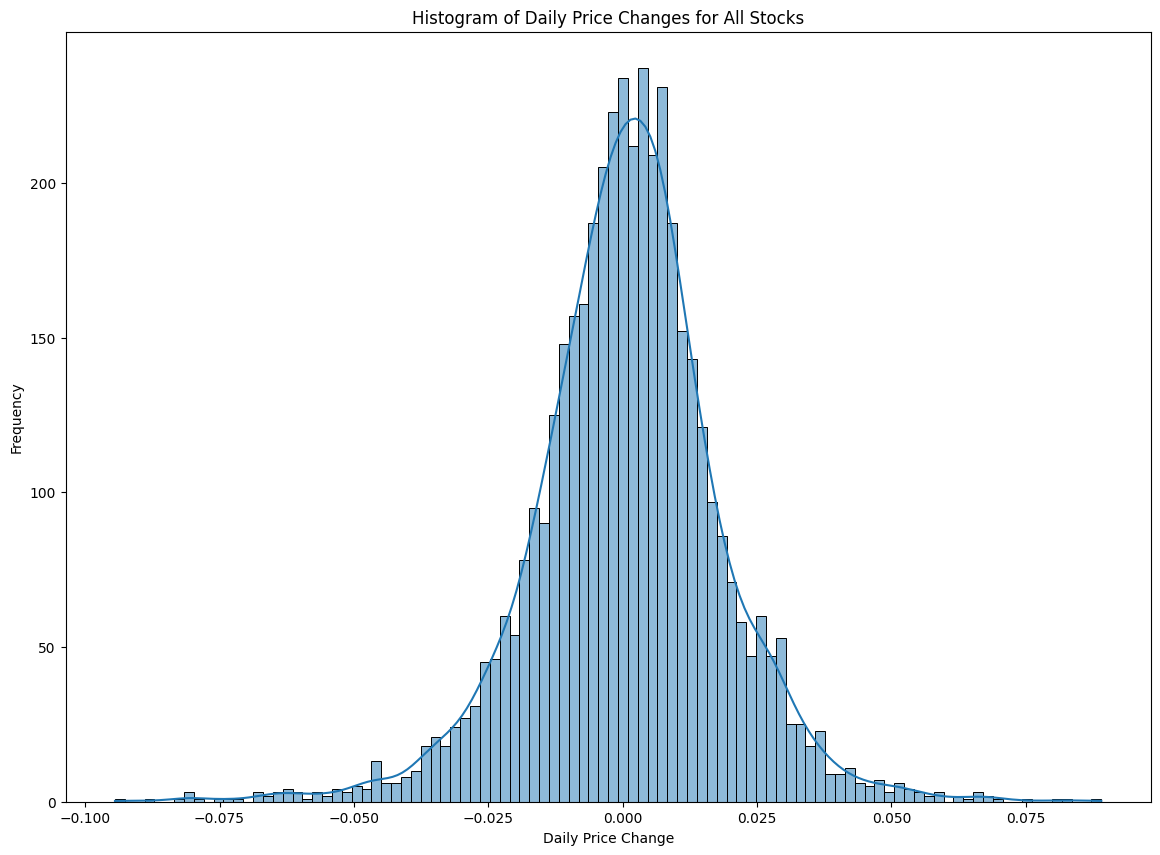

In [67]:
stock_data['price_change'] = stock_data[~stock_data['ticker'].isin(['CL=F','NG=F'])].groupby('ticker')['close'].pct_change() # percentage change

plt.figure(figsize = (14, 10))

sns.histplot(stock_data['price_change'].dropna(), bins = 100, kde = True)
plt.title('Histogram of Daily Price Changes for All Stocks')
plt.xlabel('Daily Price Change')
plt.ylabel('Frequency')
plt.savefig("plots/histogram_of_daily_price_changes_for_all_stocks.png", dpi=300, bbox_inches='tight') 
plt.show()

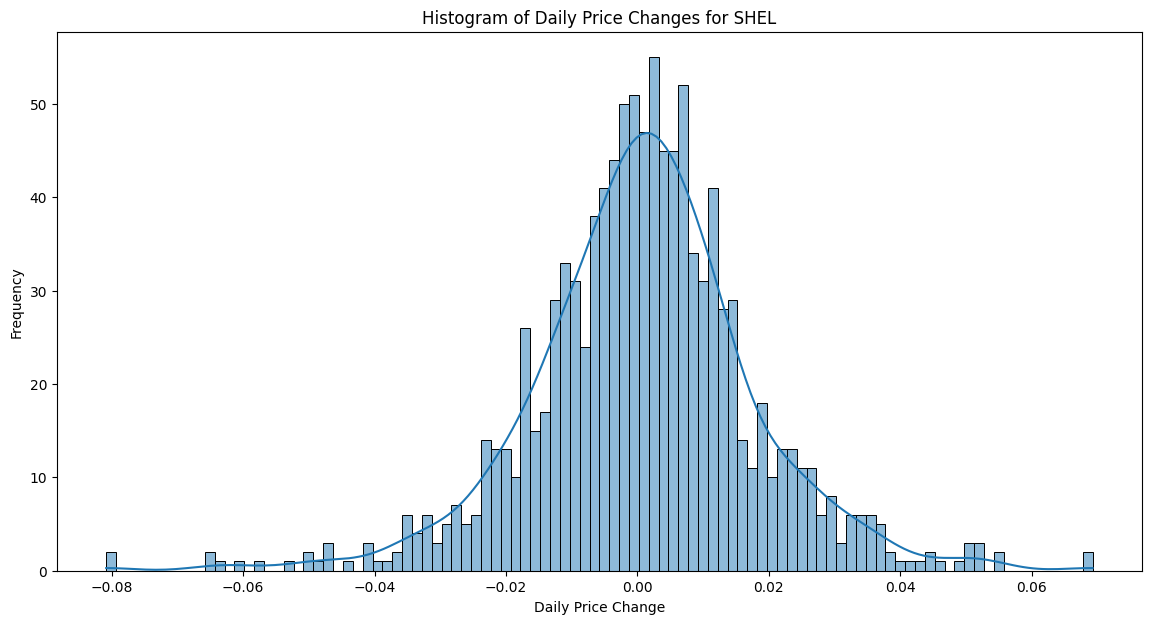

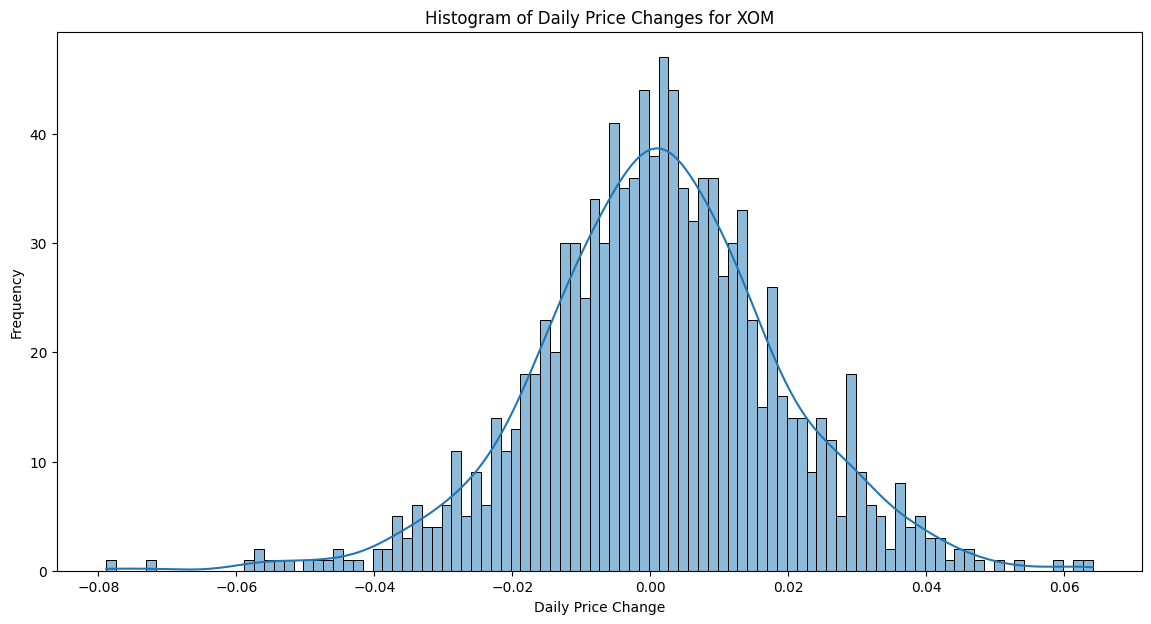

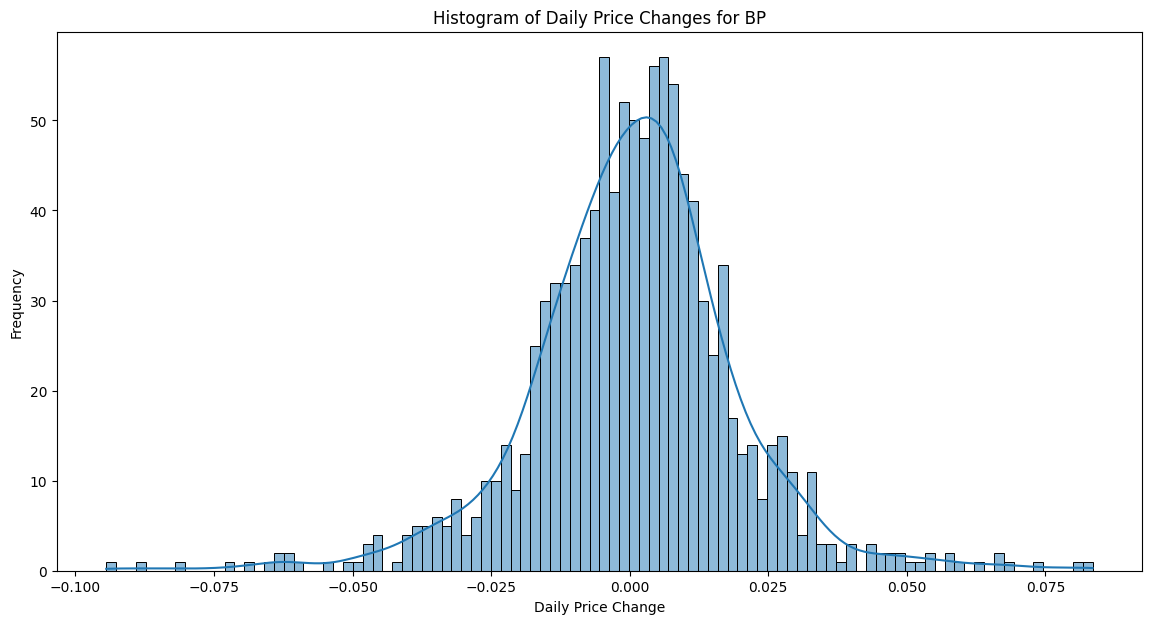

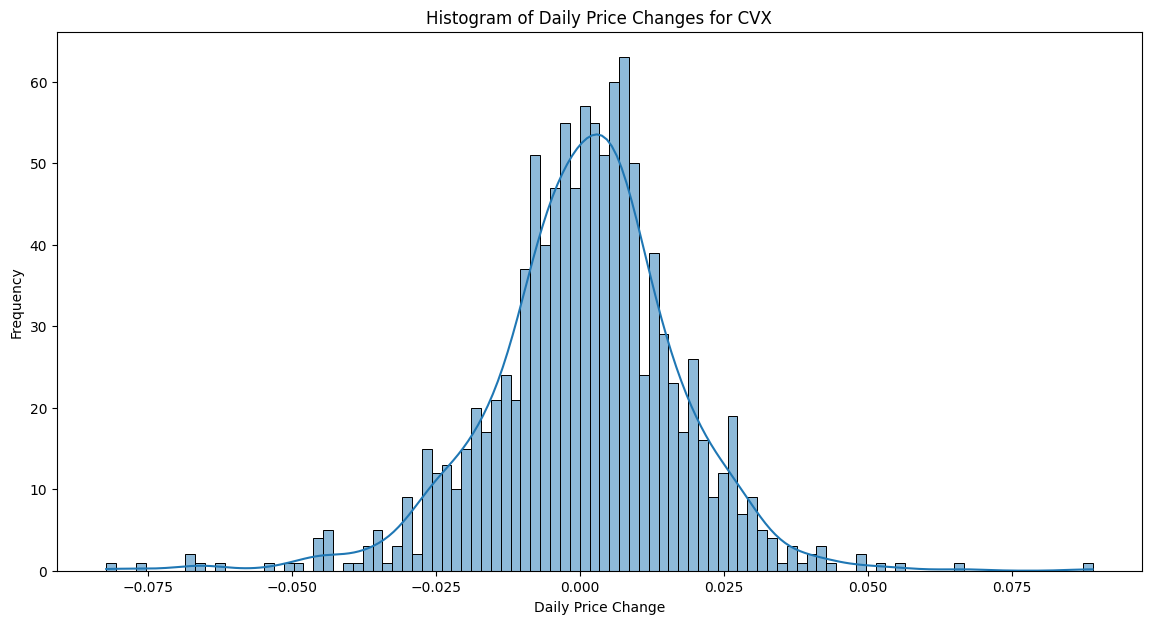

In [68]:
unique_tickers = list(tickers_names.keys())

for t in unique_tickers:
    plt.figure(figsize = (14, 7))
    sns.histplot(stock_data[stock_data['ticker'] == t]['price_change'].dropna(), bins = 100, kde = True)
    plt.title(f"Histogram of Daily Price Changes for {t}")
    plt.xlabel('Daily Price Change')
    plt.ylabel('Frequency')
    plt.savefig(f"plots/histogram_of_daily_price_changes_for_{t}.png", dpi=300, bbox_inches='tight') 
    plt.show()

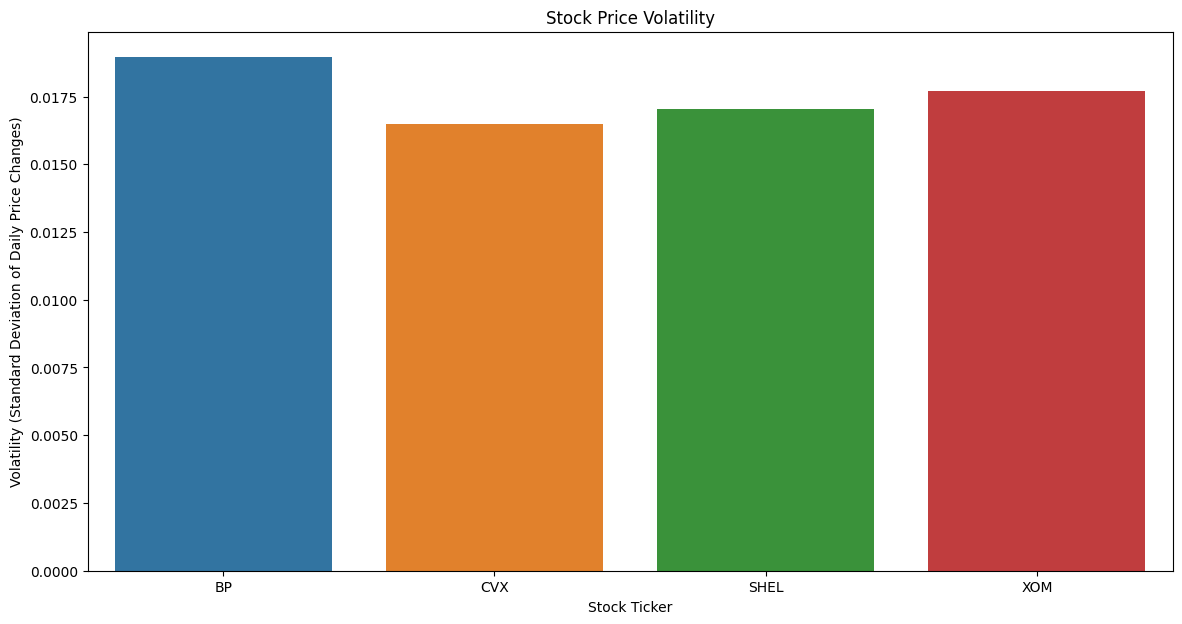

In [69]:
volatility = stock_data[~stock_data['ticker'].isin(['CL=F','NG=F'])].groupby('ticker')['price_change'].std().reset_index()
volatility.columns = ['ticker', 'volatility']

plt.figure(figsize = (14, 7))
sns.barplot(data = volatility, x = 'ticker', y = 'volatility', hue = 'ticker')
plt.title('Stock Price Volatility')
plt.xlabel('Stock Ticker')
plt.ylabel('Volatility (Standard Deviation of Daily Price Changes)')
plt.savefig("plots/stock_price_volatility.png", dpi=300, bbox_inches='tight') 
plt.show()

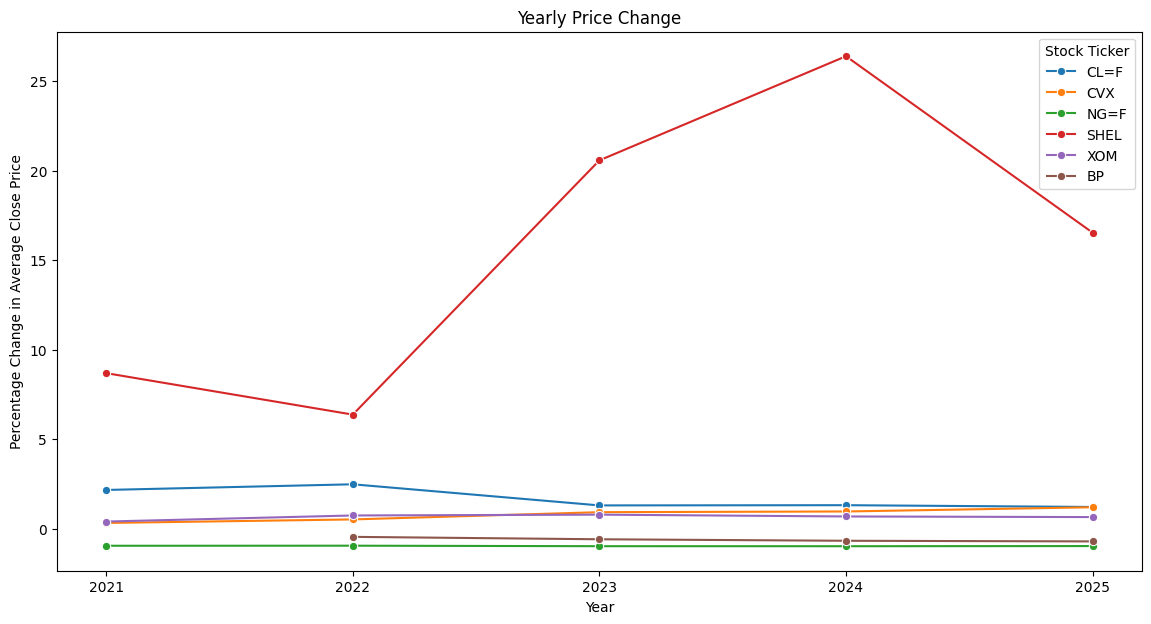

In [70]:
yearly_price_change = stock_data.groupby(['year', 'ticker'])['close'].mean().pct_change().reset_index()
yearly_price_change = yearly_price_change.dropna()

plt.figure(figsize=(14, 7))
sns.lineplot(data = yearly_price_change, x = 'year', y = 'close', hue = 'ticker', marker='o')
plt.title('Yearly Price Change')
plt.xlabel('Year')
plt.ylabel('Percentage Change in Average Close Price')
plt.xticks(ticks=yearly_price_change['year'].unique()) # Display integer instead of decimal number as year
plt.legend(title = 'Stock Ticker')
plt.savefig("plots/yearly_price_change.png", dpi=300, bbox_inches='tight') 
plt.show()

## Shell

In [71]:
shell_stock = stock_data[stock_data['ticker'] == 'SHEL']
shell_stock.set_index('date', inplace = True)

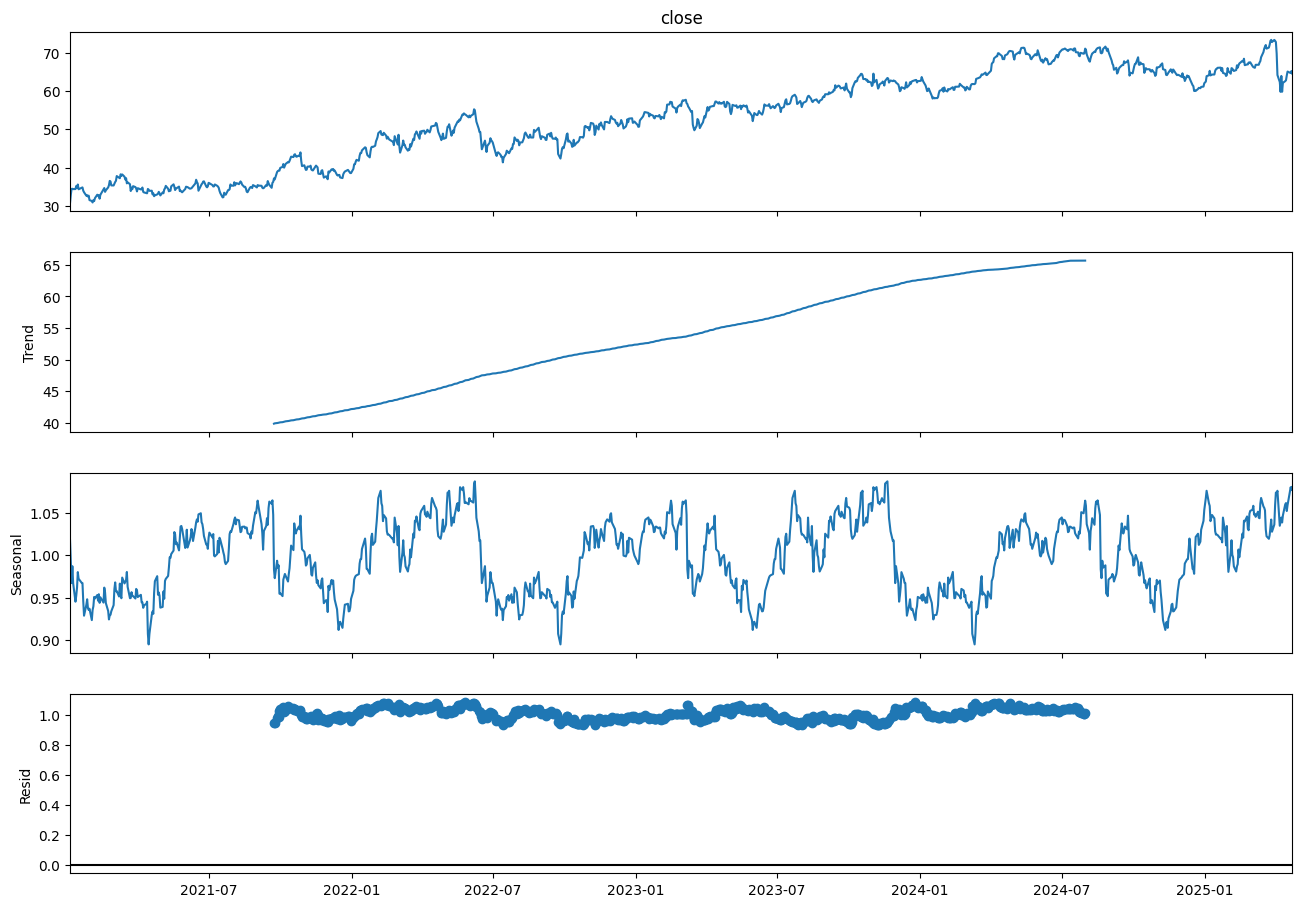

In [72]:
decomposition = seasonal_decompose(shell_stock['close'], model = 'multiplicative', period = 365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

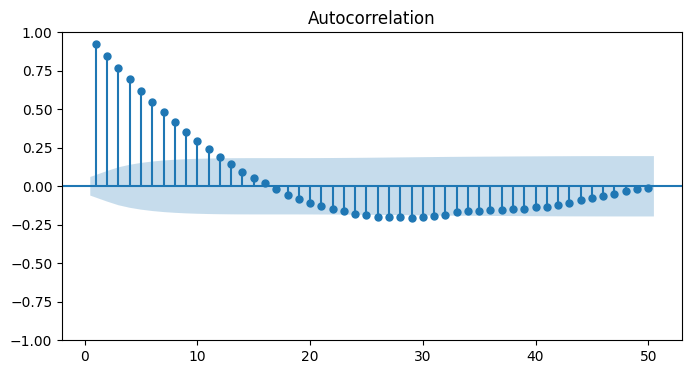

In [73]:
# Subtract long rolling average
detrend = shell_stock['close'] - shell_stock['close'].rolling(30).mean()

# Create figure
fig, ax = plt.subplots(1,1, figsize=(8,4))
# Plot ACF
plot_acf(detrend.dropna(), ax=ax, lags=50, zero=False)
plt.show()

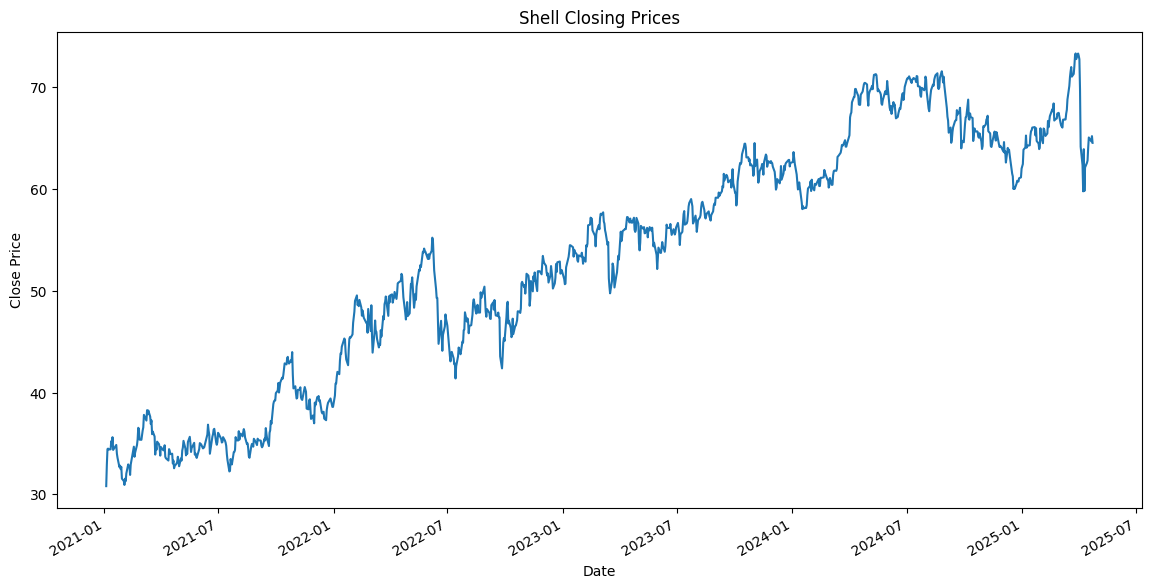

In [74]:
plt.figure(figsize=(14, 7))
shell_stock['close'].plot()
plt.title("Shell Closing Prices")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

C:\Users\Ying\AppData\Local\Temp\ipykernel_23664\1717016293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shell_stock['rolling_mean'] = shell_stock['close'].rolling(window = 30).mean()


<Figure size 1400x700 with 0 Axes>

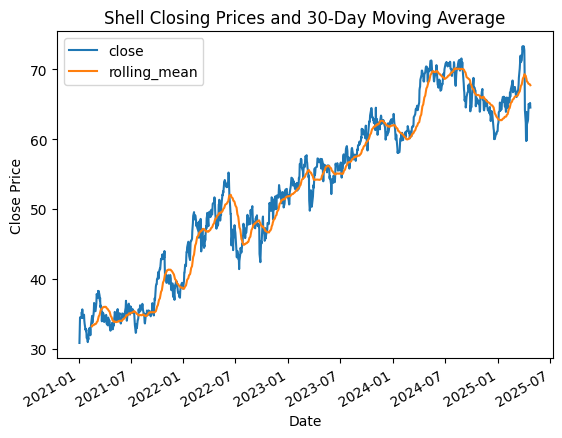

In [75]:
shell_stock['rolling_mean'] = shell_stock['close'].rolling(window = 30).mean()

plt.figure(figsize=(14, 7))
shell_stock[['close', 'rolling_mean']].plot()
plt.title('Shell Closing Prices and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

## Chevron

In [76]:
cvx_stock = stock_data[stock_data['ticker'] == 'CVX']
cvx_stock.set_index('date', inplace = True)

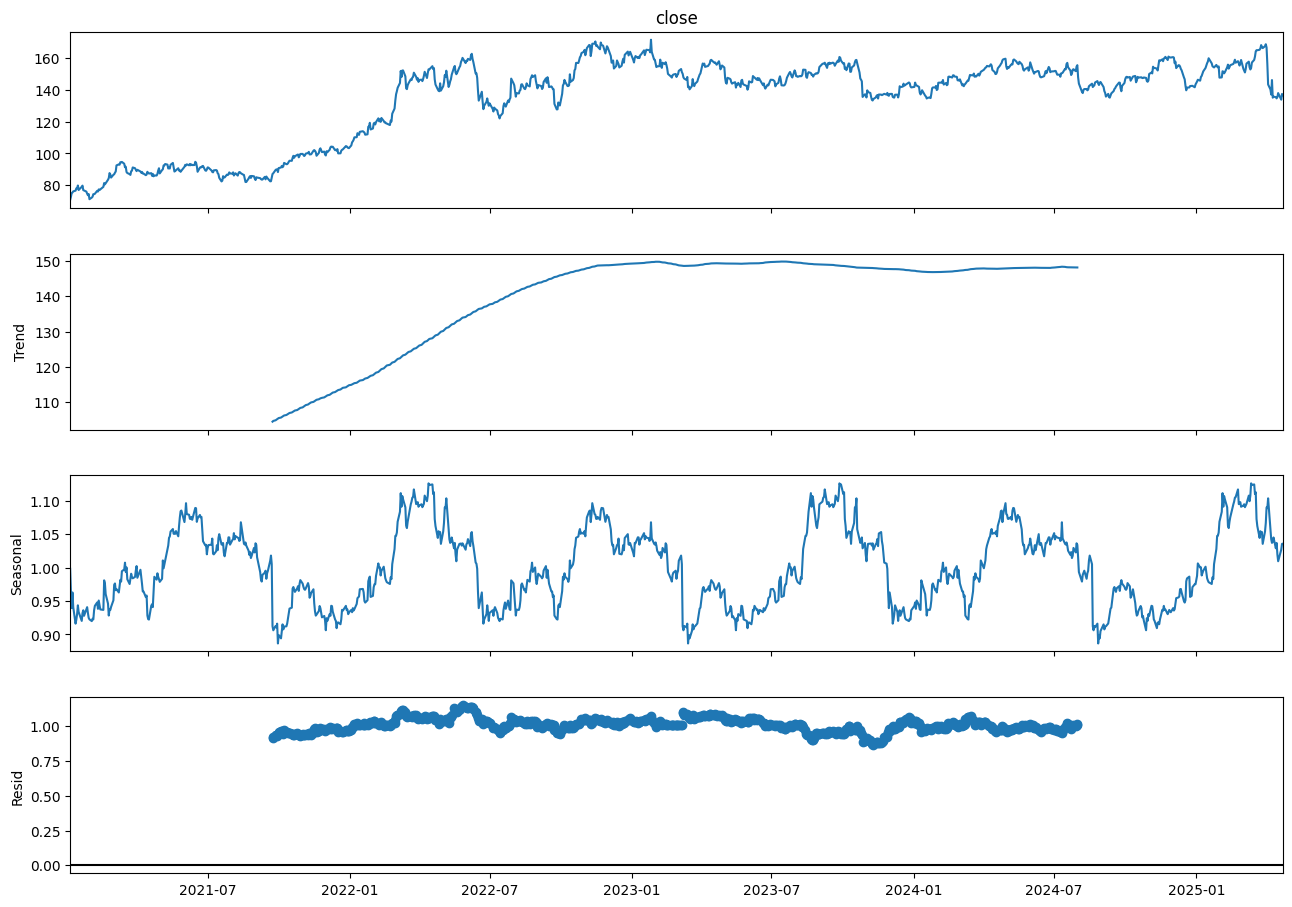

In [77]:
decomposition = seasonal_decompose(cvx_stock['close'], model = 'multiplicative', period = 365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

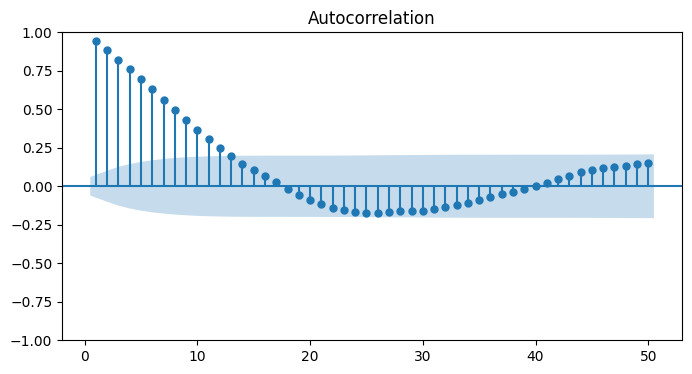

In [78]:
# Subtract long rolling average
detrend = cvx_stock['close'] - cvx_stock['close'].rolling(30).mean()

# Create figure
fig, ax = plt.subplots(1,1, figsize=(8,4))
# Plot ACF
plot_acf(detrend.dropna(), ax=ax, lags=50, zero=False)
plt.show()

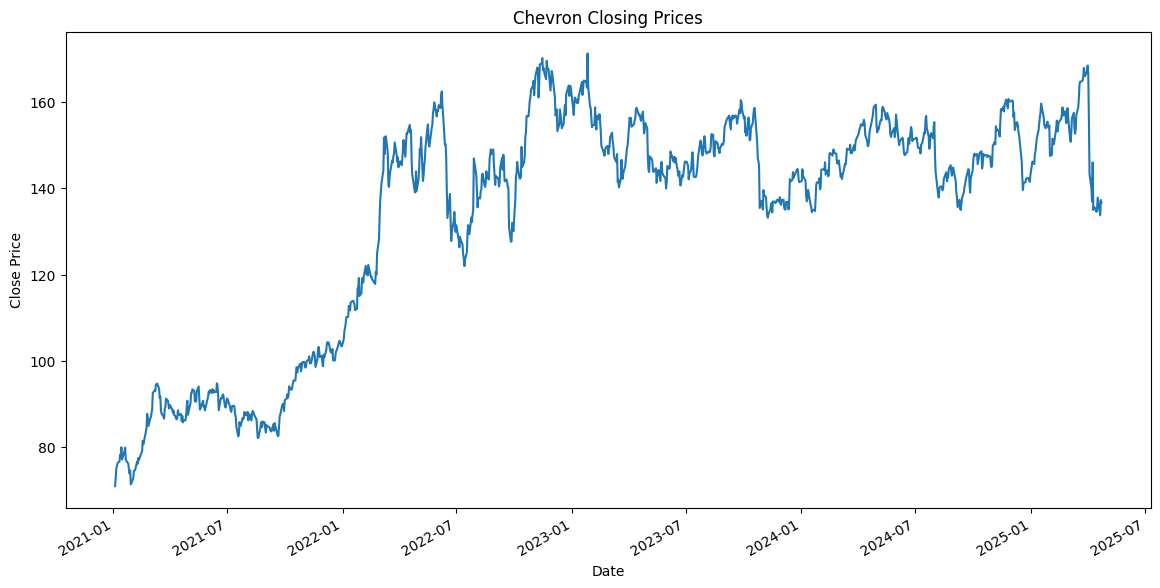

In [79]:
plt.figure(figsize = (14, 7))
cvx_stock['close'].plot()
plt.title('Chevron Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

C:\Users\Ying\AppData\Local\Temp\ipykernel_23664\1352409153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvx_stock['rolling_mean'] = cvx_stock['close'].rolling(window = 30).mean()


<Figure size 1400x700 with 0 Axes>

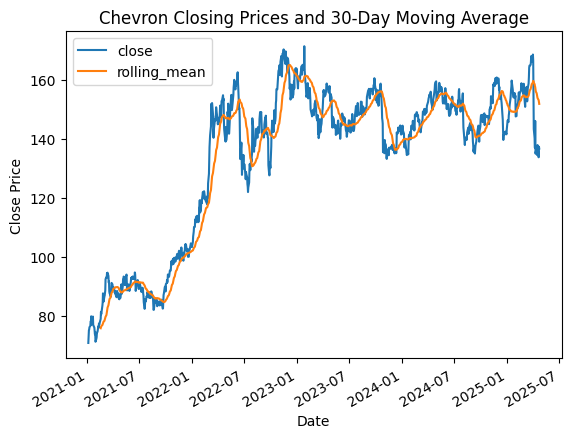

In [80]:
cvx_stock['rolling_mean'] = cvx_stock['close'].rolling(window = 30).mean()

plt.figure(figsize = (14, 7))
cvx_stock[['close', 'rolling_mean']].plot()
plt.title('Chevron Closing Prices and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# ADF Test & PACF Plot & ACF Plot

adf test_p-value when d = 0: 0.41684530837497225
adf test_p-value when d = 1: 0.0
Final d = 1


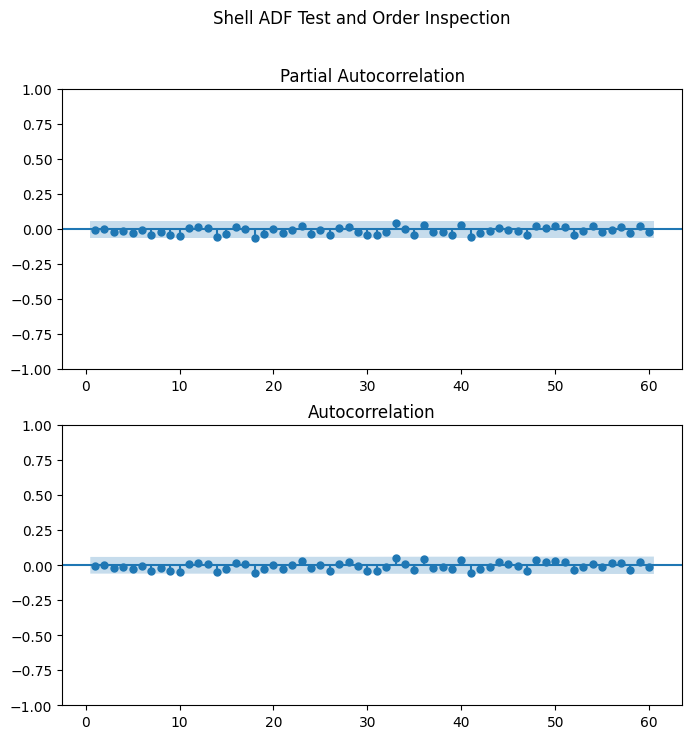

adf test_p-value when d = 0: 0.26050971380605364
adf test_p-value when d = 1: 0.0
Final d = 1


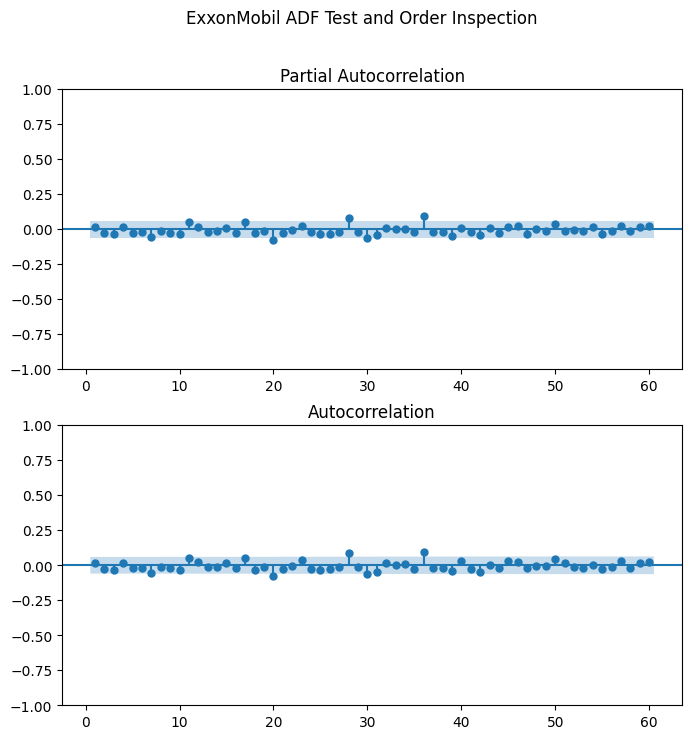

adf test_p-value when d = 0: 0.15419198118320115
adf test_p-value when d = 1: 0.0
Final d = 1


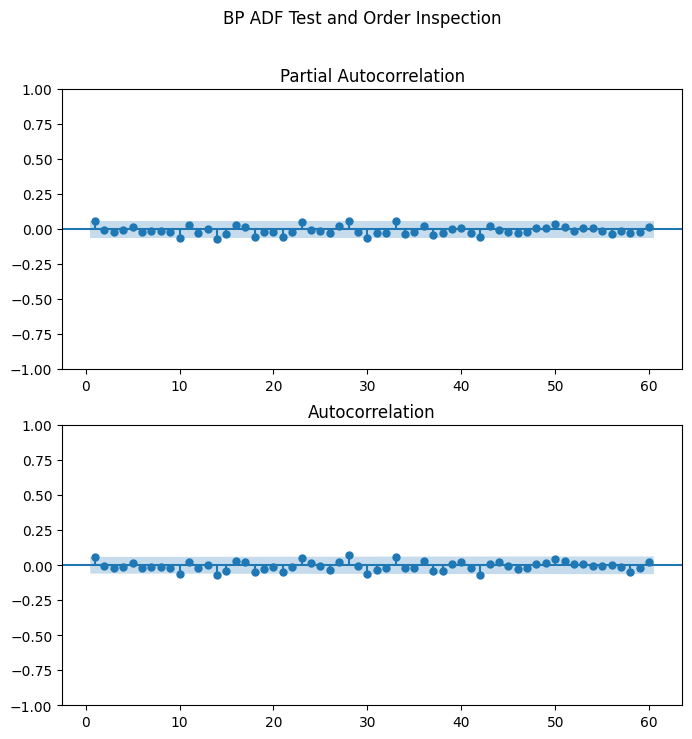

adf test_p-value when d = 0: 0.14831414758169476
adf test_p-value when d = 1: 0.0
Final d = 1


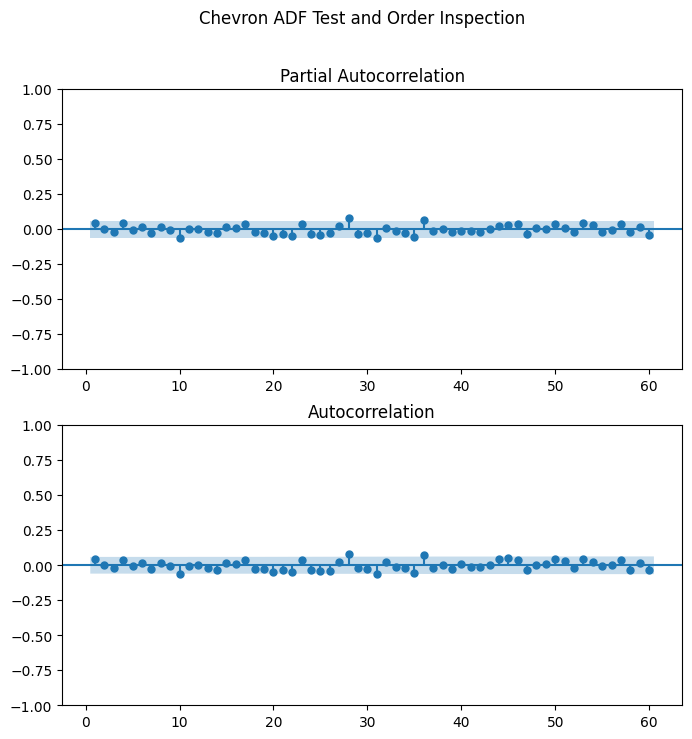

In [81]:
stock_data.set_index('date', inplace = True)

for ticker in list(tickers_names.keys()):
    df = stock_data[stock_data['ticker'] == ticker]['close']
    adf_result = adfuller(df)[1]
    d = 0
    print(f"adf test_p-value when d = {d}: {adf_result}")
    while adf_result >= 0.05 and d < 2:
        df = df.diff().dropna()
        d += 1
        adf_result = adfuller(df)[1]
        print(f"adf test_p-value when d = {d}: {adf_result}")
    print(f"Final d = {d}")
    fig,(ax1, ax2) = plt.subplots(2, 1, figsize = (8,8))
    fig.suptitle(f"{tickers_names[ticker]} ADF Test and Order Inspection")
    ax1.set_title('PACF')
    ax2.set_title('ACF')
    plot_pacf(df, lags = 60, zero = False, ax = ax1)
    plot_acf(df, lags = 60, zero = False, ax = ax2)
    plt.show()
    

# Prediction

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1081
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1360.266
Date:                Thu, 24 Apr 2025   AIC                           2722.532
Time:                        23:54:28   BIC                           2727.517
Sample:                             0   HQIC                          2724.419
                               - 1081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.7270      0.019     38.905      0.000       0.690       0.764
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               671.53
Prob(Q):                              0.92   Pr

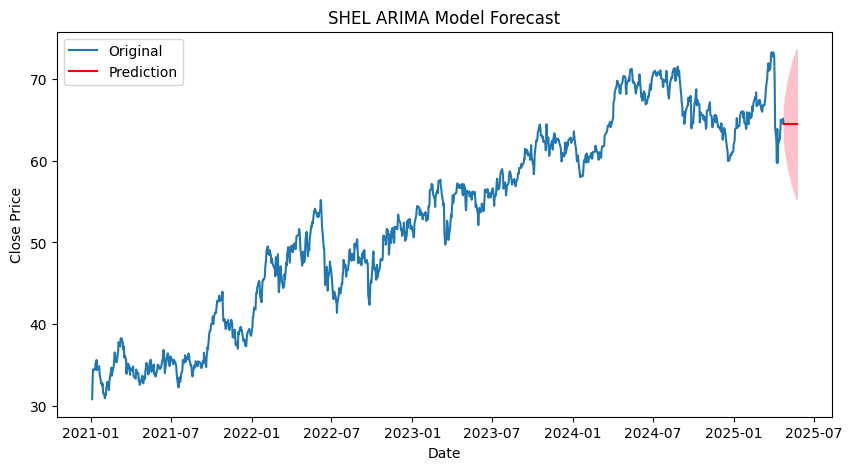

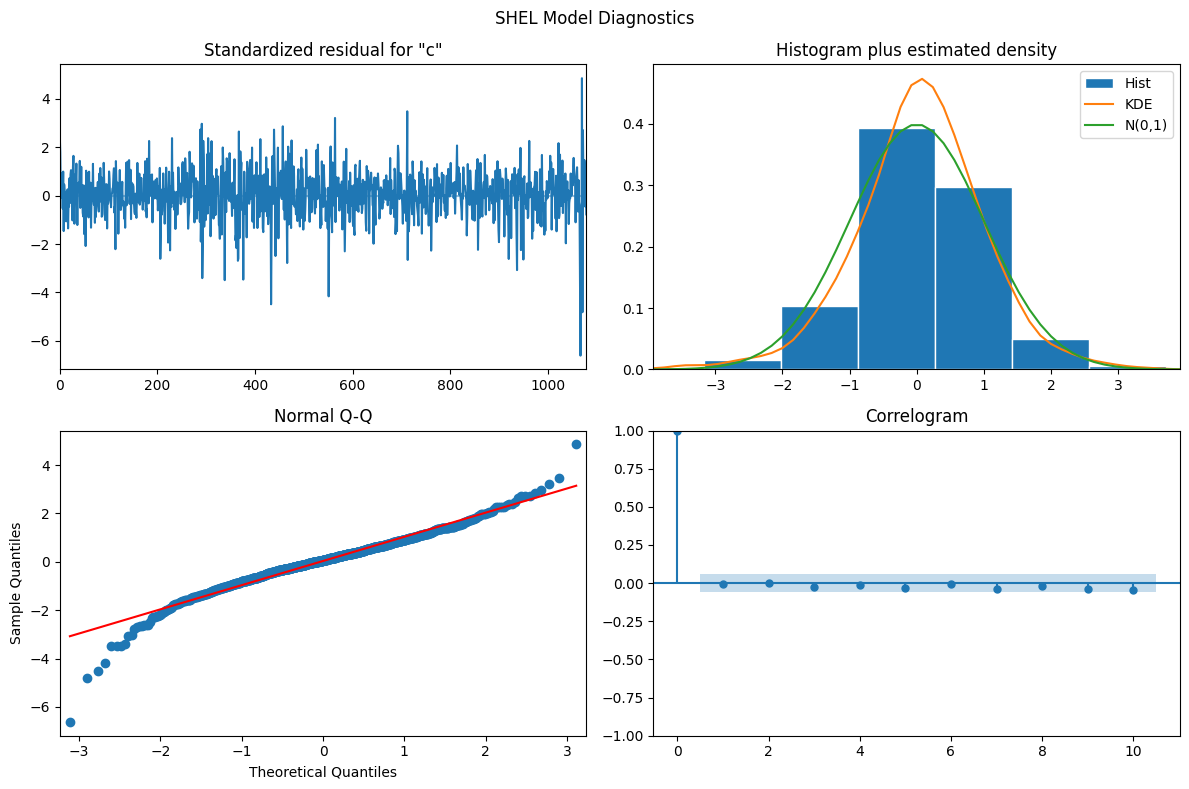

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1081
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1985.983
Date:                Thu, 24 Apr 2025   AIC                           3973.966
Time:                        23:54:29   BIC                           3978.951
Sample:                             0   HQIC                          3975.853
                               - 1081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.3160      0.072     32.293      0.000       2.175       2.457
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):               193.39
Prob(Q):                              0.56   Pr

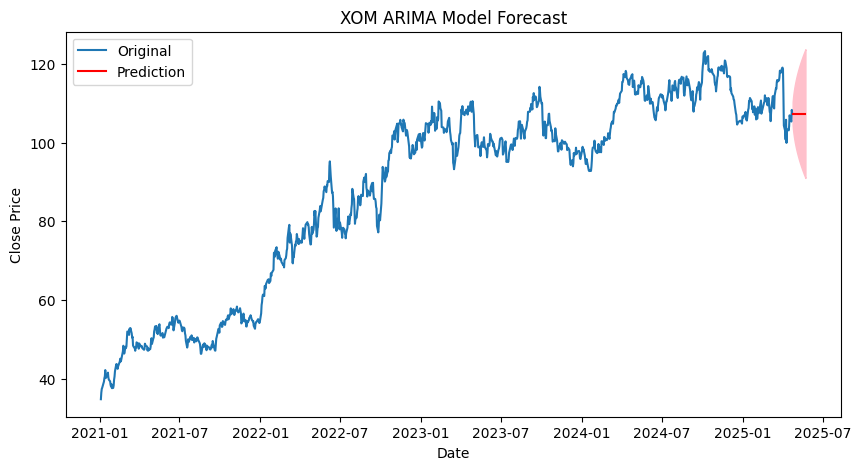

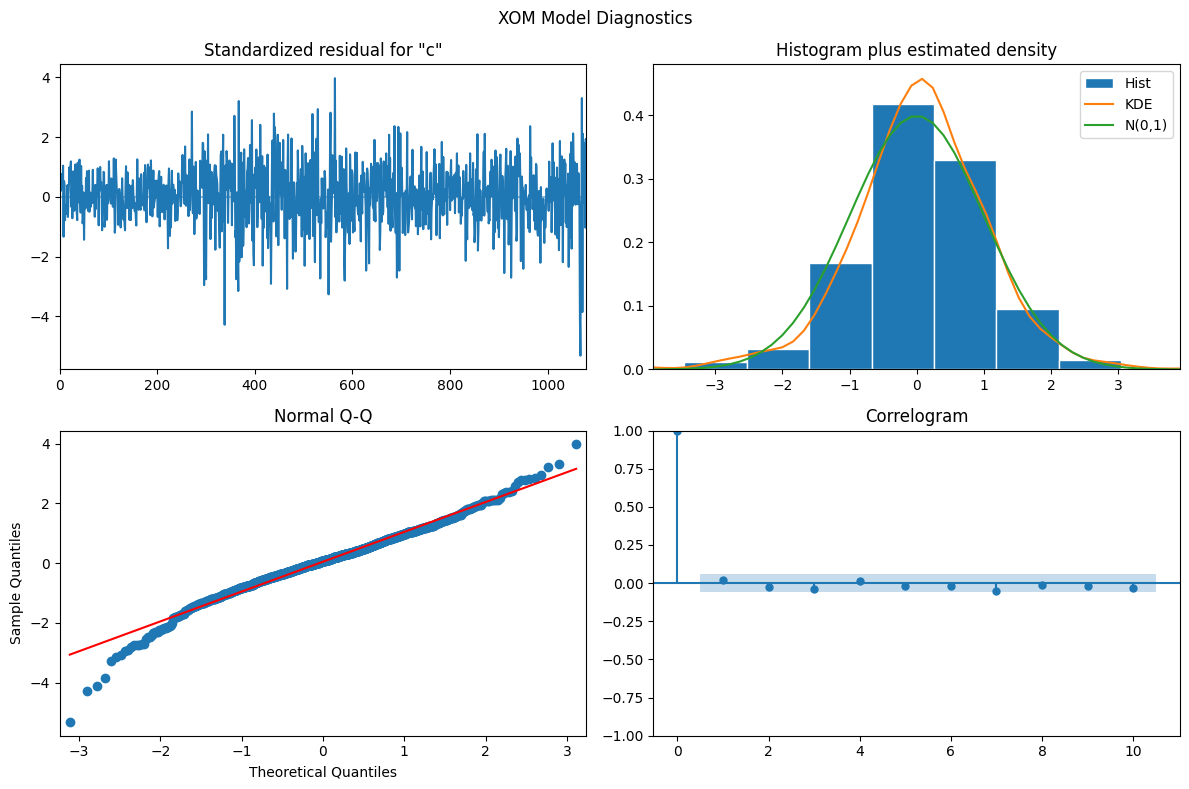

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1081
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -831.763
Date:                Thu, 24 Apr 2025   AIC                           1665.526
Time:                        23:54:30   BIC                           1670.511
Sample:                             0   HQIC                          1667.413
                               - 1081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2732      0.007     40.292      0.000       0.260       0.286
Ljung-Box (L1) (Q):                   3.66   Jarque-Bera (JB):               784.00
Prob(Q):                              0.06   Pr

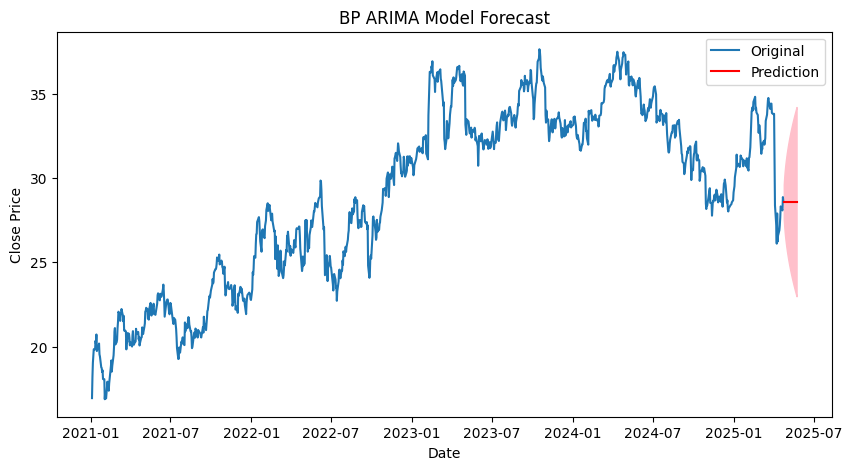

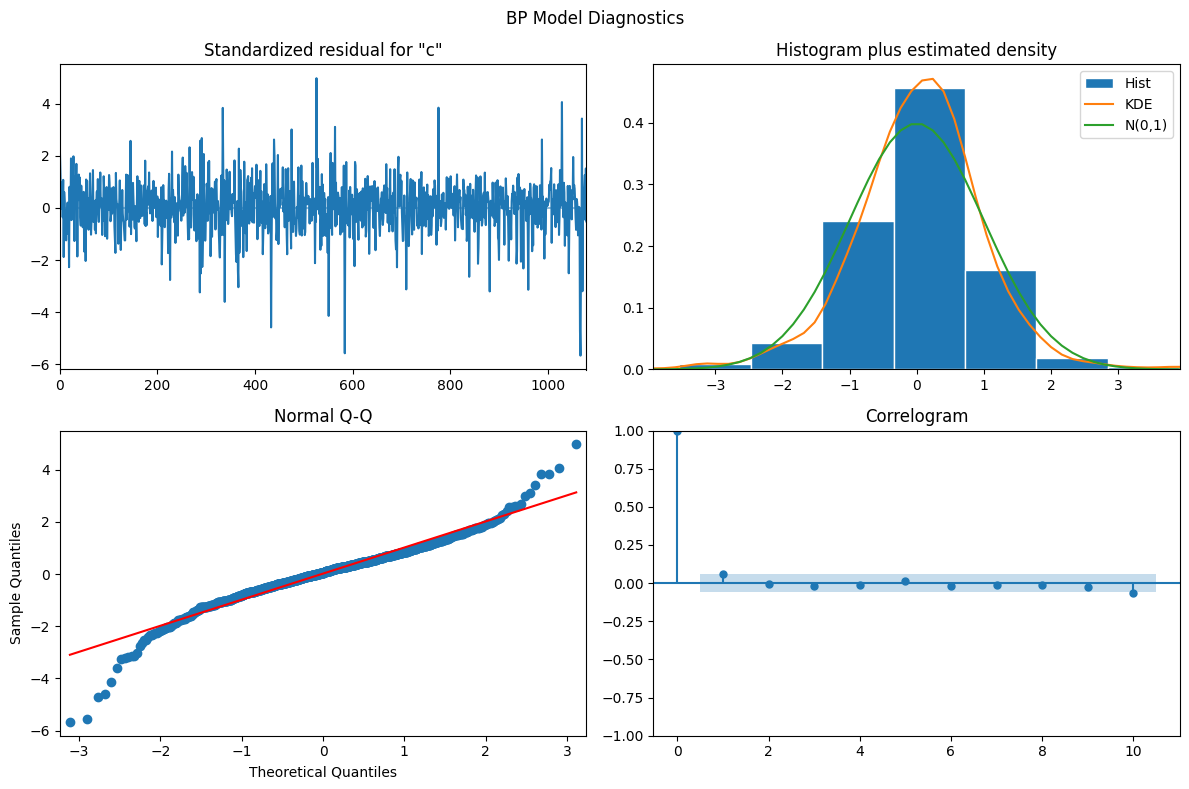

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1081
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2409.169
Date:                Thu, 24 Apr 2025   AIC                           4820.338
Time:                        23:54:31   BIC                           4825.322
Sample:                             0   HQIC                          4822.225
                               - 1081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.0710      0.126     40.211      0.000       4.824       5.318
Ljung-Box (L1) (Q):                   2.12   Jarque-Bera (JB):               807.23
Prob(Q):                              0.15   Pr

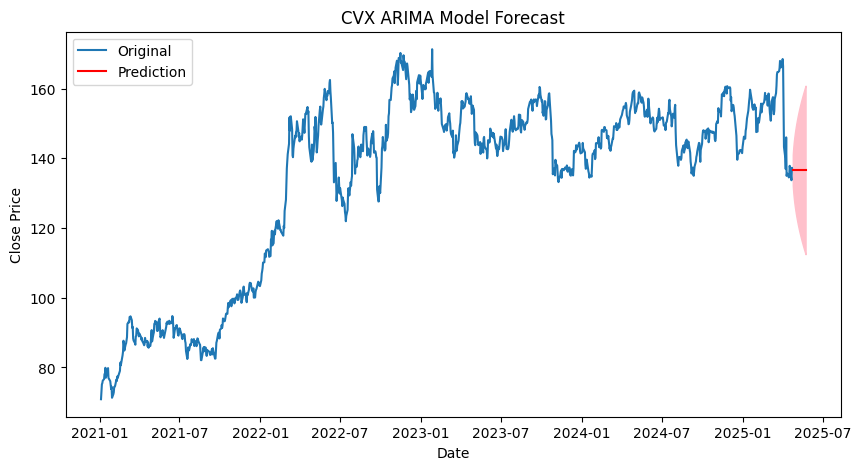

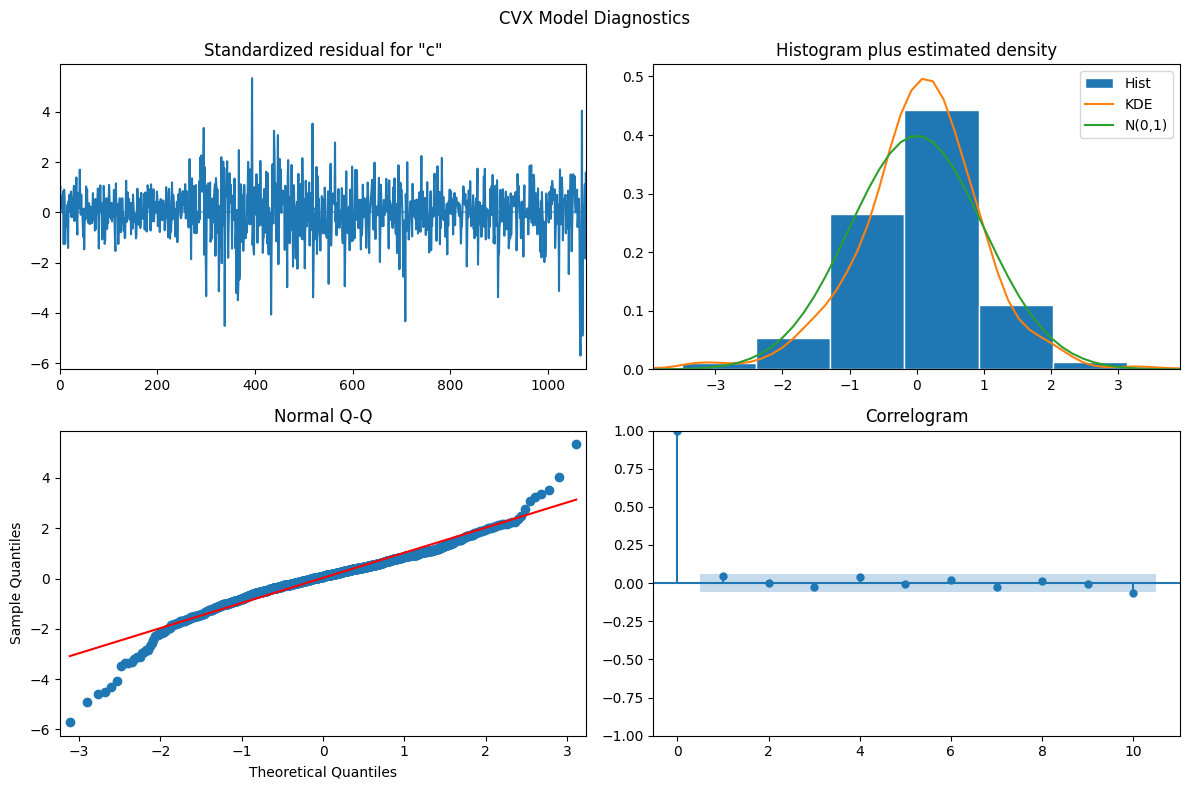

In [82]:

for ticker in list(tickers_names.keys()):
    df = stock_data[stock_data['ticker']==ticker]['close']

    model = ARIMA(df, order = (0,1,0))
    results = model.fit()
    print(results.summary())

    predict = results.get_forecast(steps = 30)
    last_date = stock_data[stock_data['ticker'] == ticker].index.max()
    predict_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
    # predict_index = pd.date_range(start = df[-1], periods = 30, freq = 'D')
    predict_mean = predict.predicted_mean
    predict_conf_int = predict.conf_int()

    plt.figure(figsize = (10,5))
    plt.plot(df, label = 'Original')
    plt.plot(predict_index, predict_mean, color = 'red', label = 'Prediction')
    plt.fill_between(predict_index, predict_conf_int.iloc[:,0], predict_conf_int.iloc[:,1], color = 'pink')
    plt.title(f"{ticker} ARIMA Model Forecast")
    plt.xlabel("Date")
    plt.ylabel('Close Price')
    plt.legend()
    plt.savefig(f"plots/predictions/{ticker}_ARIMA_model_forecast.png", dpi=300, bbox_inches='tight') 
    plt.show()

    diag_fig = results.plot_diagnostics(figsize = (12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.show()






## Prediction with Train Test Split

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


SHEL Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1050.724
Date:                Thu, 24 Apr 2025   AIC                           2103.448
Time:                        23:54:32   BIC                           2108.208
Sample:                             0   HQIC                          2105.270
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.6684      0.024     27.818      0.000       0.621       0.716
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               108.54
Prob(Q):                  

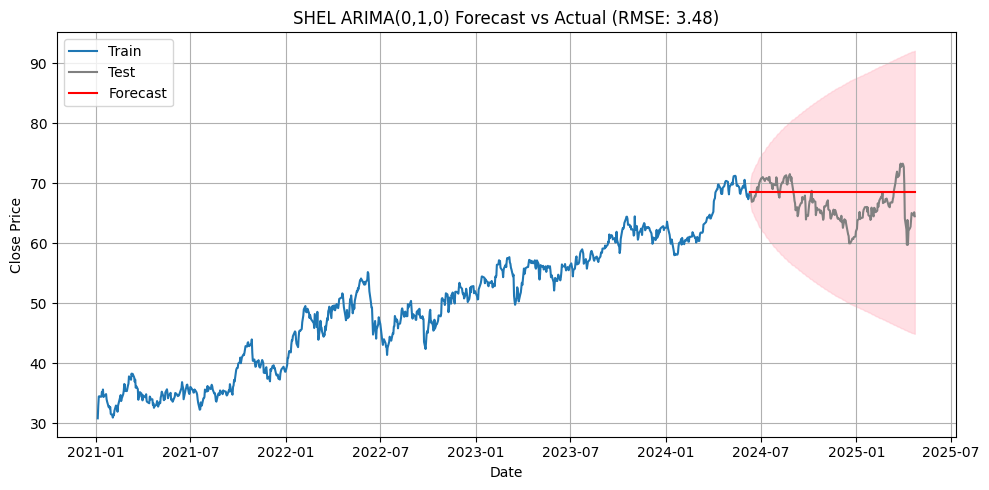

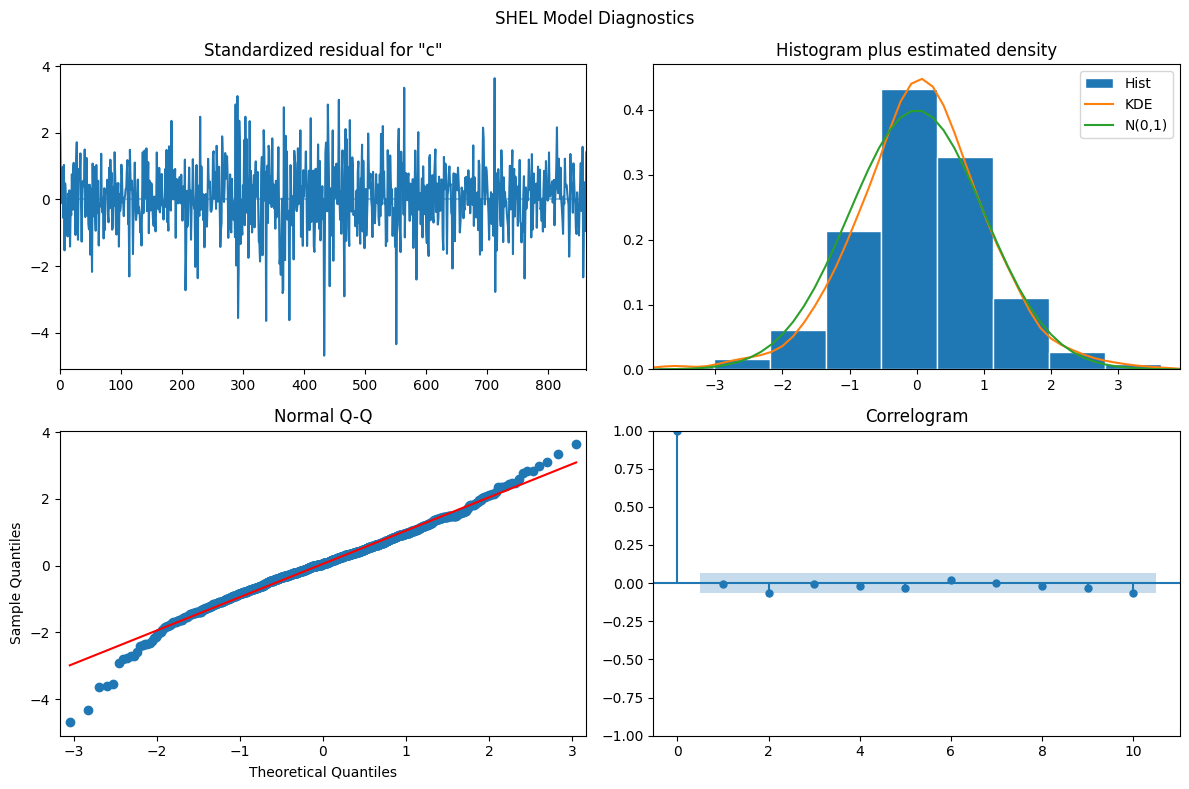

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


XOM Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1557.906
Date:                Thu, 24 Apr 2025   AIC                           3117.812
Time:                        23:54:34   BIC                           3122.572
Sample:                             0   HQIC                          3119.634
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.1653      0.081     26.725      0.000       2.007       2.324
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                71.96
Prob(Q):                   

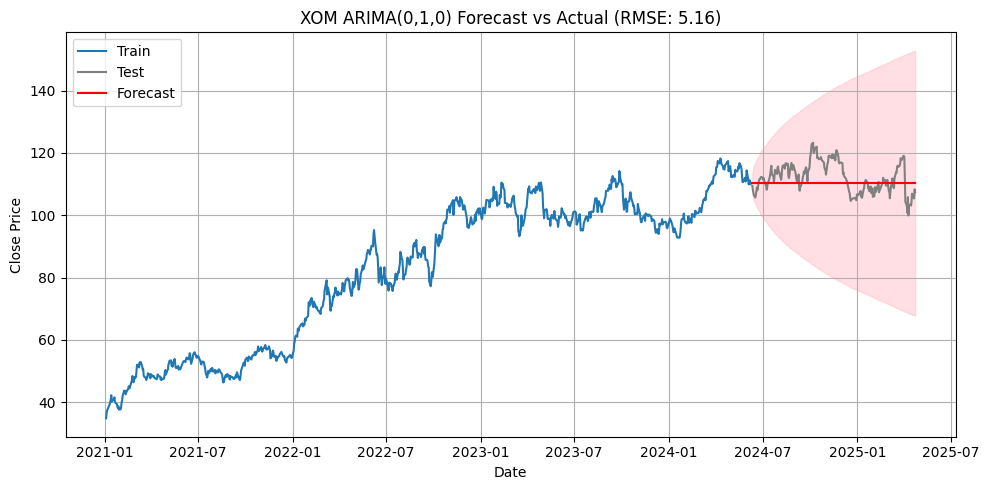

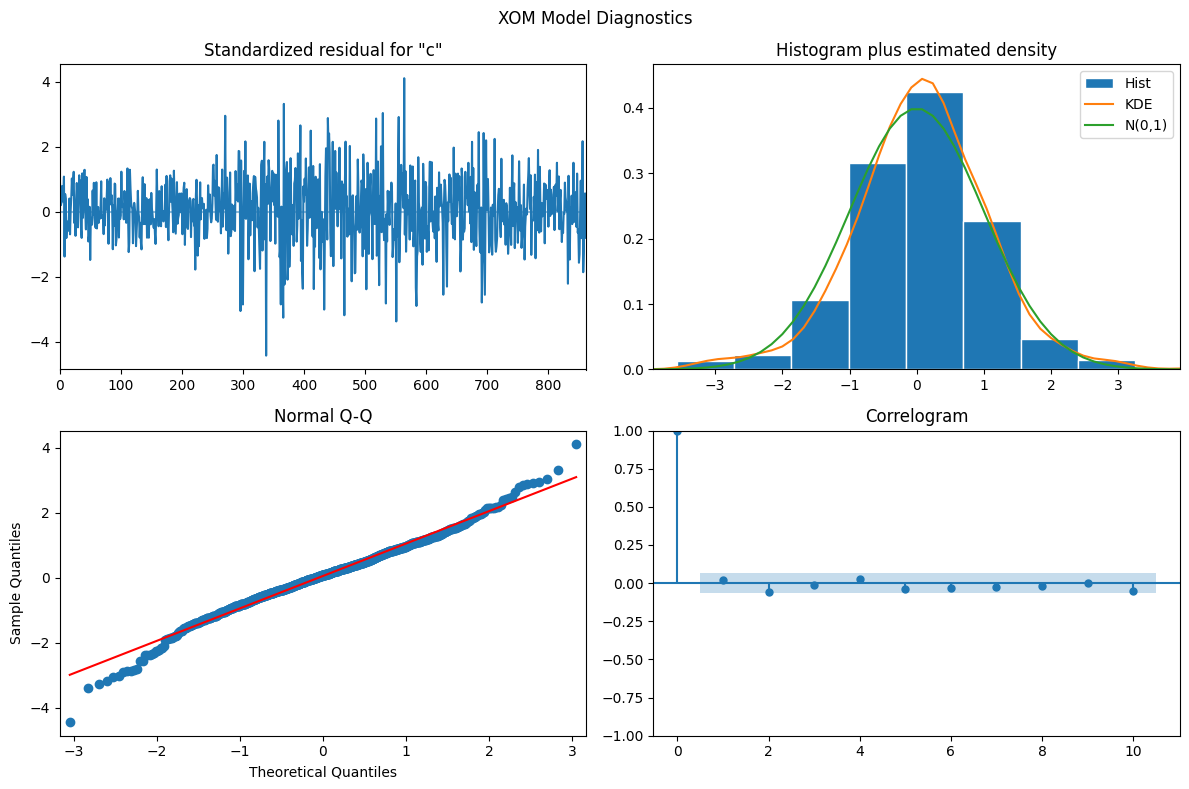

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


BP Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -647.411
Date:                Thu, 24 Apr 2025   AIC                           1296.822
Time:                        23:54:35   BIC                           1301.582
Sample:                             0   HQIC                          1298.644
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2625      0.008     33.628      0.000       0.247       0.278
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):               400.83
Prob(Q):                    

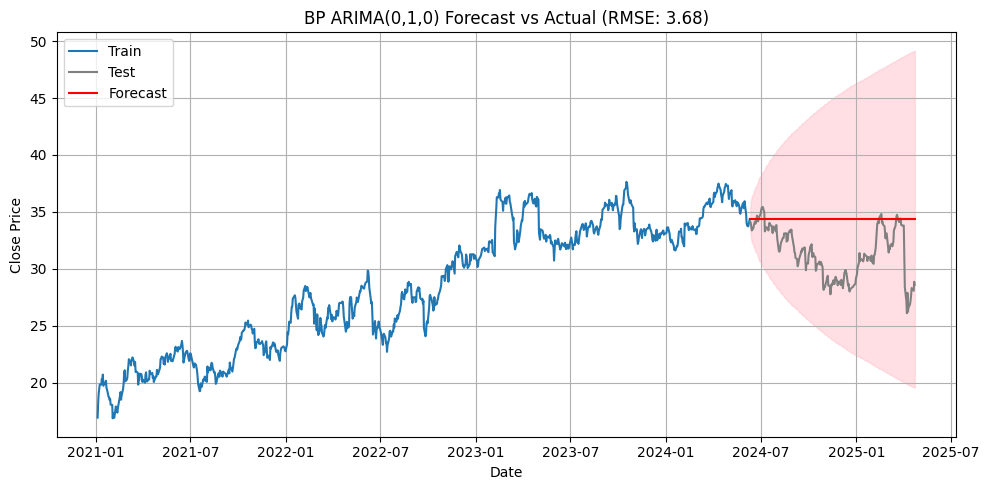

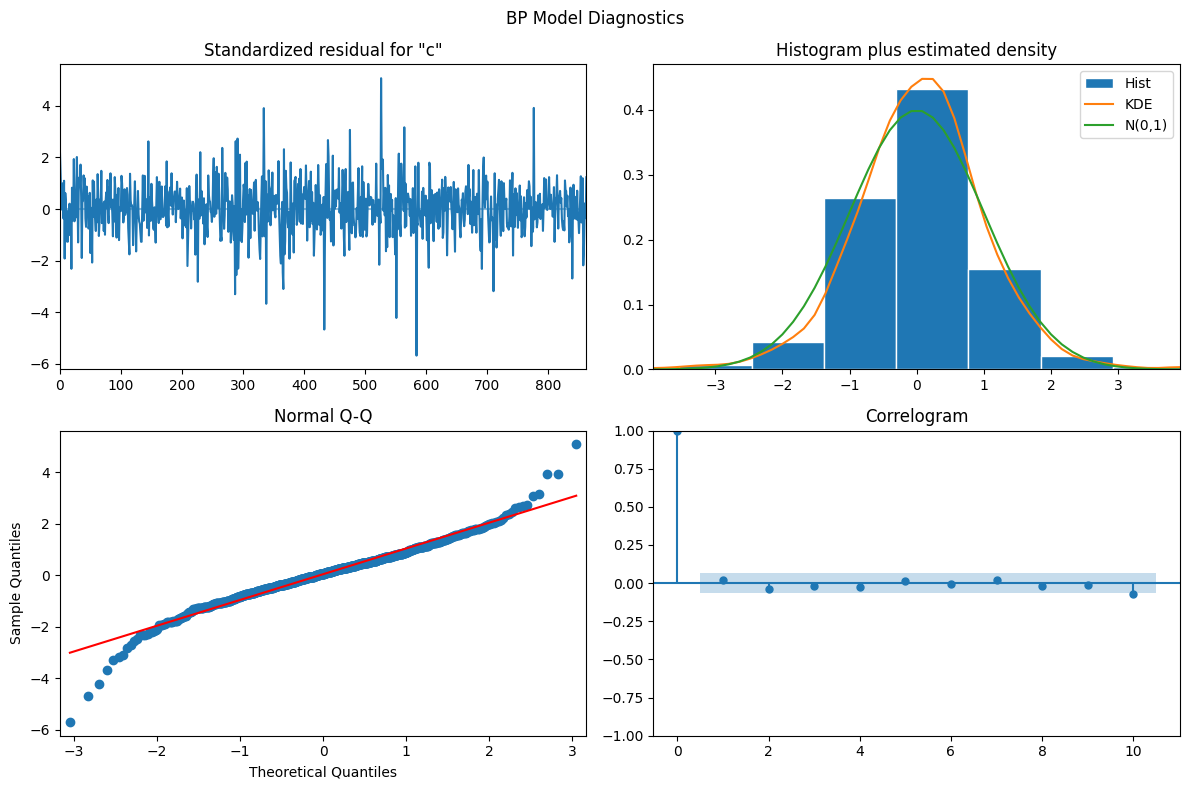

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


CVX Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1904.428
Date:                Thu, 24 Apr 2025   AIC                           3810.856
Time:                        23:54:37   BIC                           3815.617
Sample:                             0   HQIC                          3812.679
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.8338      0.147     32.777      0.000       4.545       5.123
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):               346.27
Prob(Q):                   

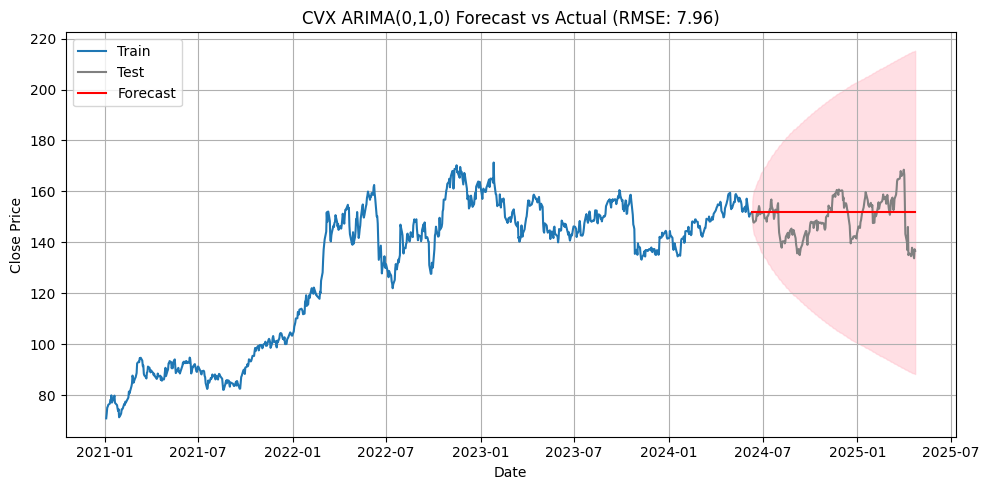

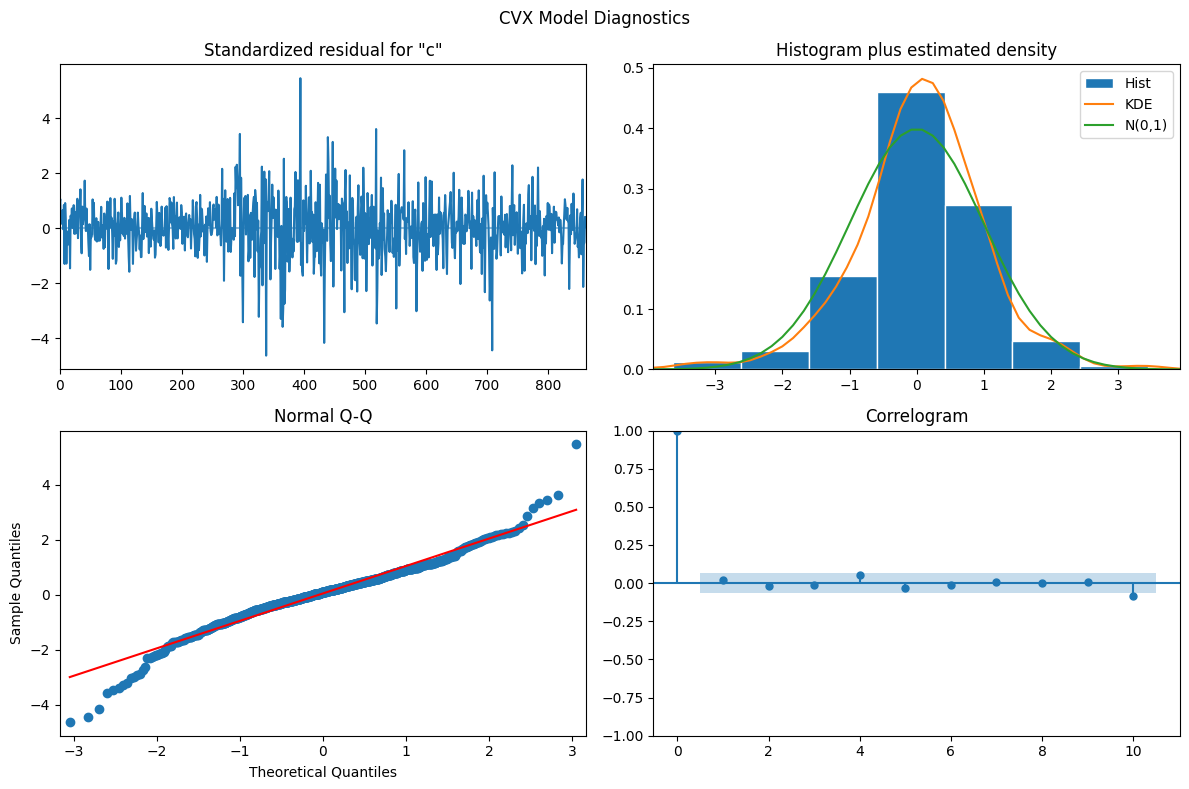

In [83]:
rmse_dict = {}

for ticker in tickers_names.keys():
    df = stock_data[stock_data['ticker'] == ticker]['close'].copy()
    
    # Train-test split (80% train, 20% test)
    split_idx = int(len(df) * 0.8)
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    
    # Fit ARIMA model on training data
    model = ARIMA(train, order=(0, 1, 0))
    results = model.fit()
    print(f"\n{ticker} Model Summary:")
    print(results.summary())
    
    # Forecast for length of test set
    forecast = results.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))
    rmse_dict[ticker] = rmse
    print(f"{ticker} RMSE on test set: {rmse:.2f}")
    
    # Plot actual vs forecast
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='gray')
    plt.plot(test.index, forecast_mean, label='Forecast', color='red')
    plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
    plt.title(f"{ticker} ARIMA(0,1,0) Forecast vs Actual (RMSE: {rmse:.2f})")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/predictions/{ticker}_arima_model_forecast_vs_actual.png", dpi=300, bbox_inches='tight') 
    plt.show()
    
    # Plot diagnostics
    diag_fig = results.plot_diagnostics(figsize=(12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.savefig(f"plots/predictions/{ticker}_model_diagnostics.png", dpi=300, bbox_inches='tight')
    plt.show()

## Prediction with Crude Oil Price Data

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


SHEL Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -908.427
Date:                Thu, 24 Apr 2025   AIC                           1820.855
Time:                        23:54:39   BIC                           1830.376
Sample:                             0   HQIC                          1824.499
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.2089      0.007     28.124      0.000       0.194       0.224
sigma2         0.4807      0.016     29.808      0.000       0.449       0.512
Ljung-Box (L1) (Q):            

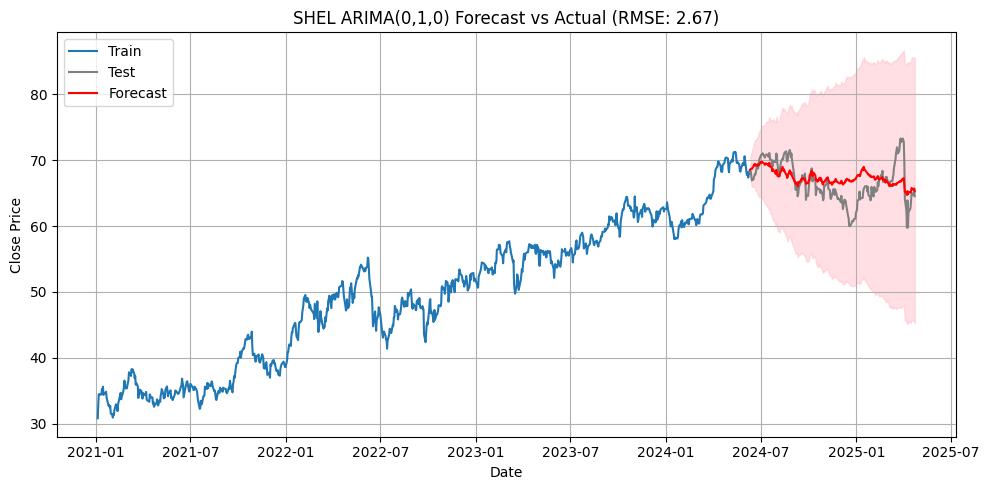

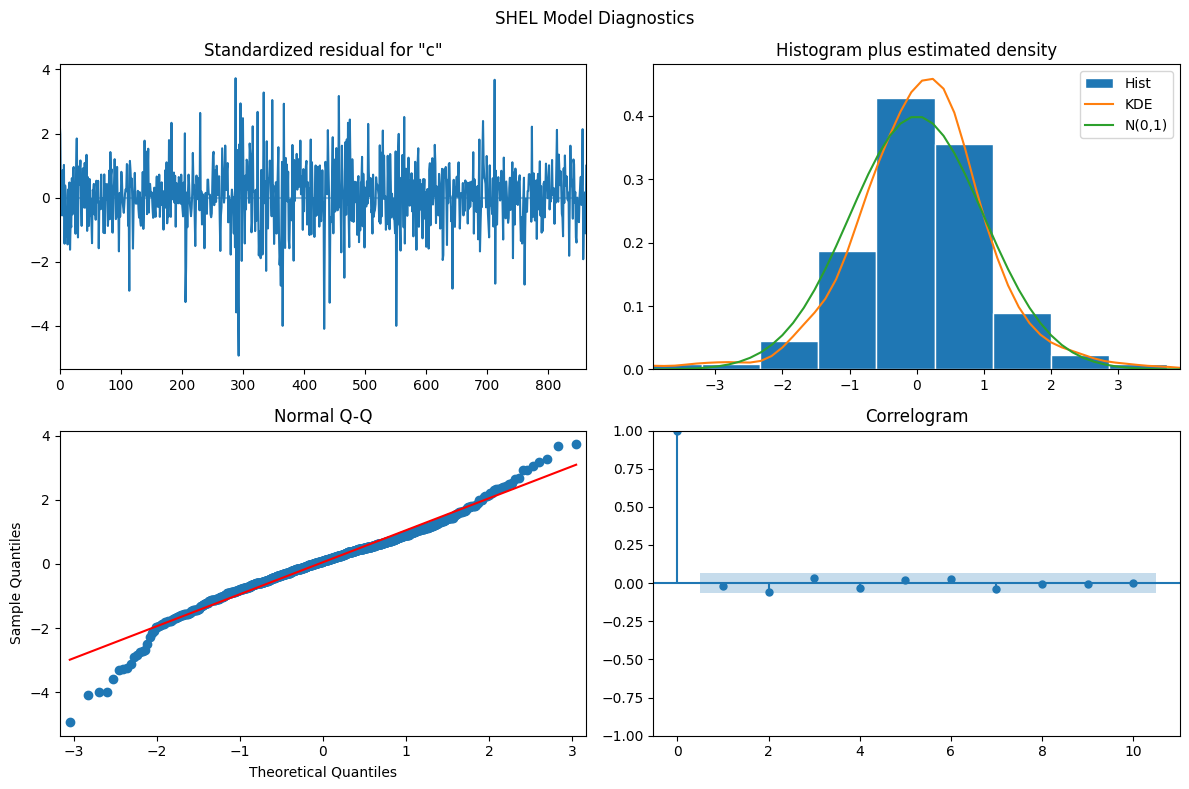

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


XOM Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1366.895
Date:                Thu, 24 Apr 2025   AIC                           2737.789
Time:                        23:54:41   BIC                           2747.310
Sample:                             0   HQIC                          2741.433
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.4244      0.015     28.442      0.000       0.395       0.454
sigma2         1.3908      0.052     26.566      0.000       1.288       1.493
Ljung-Box (L1) (Q):             

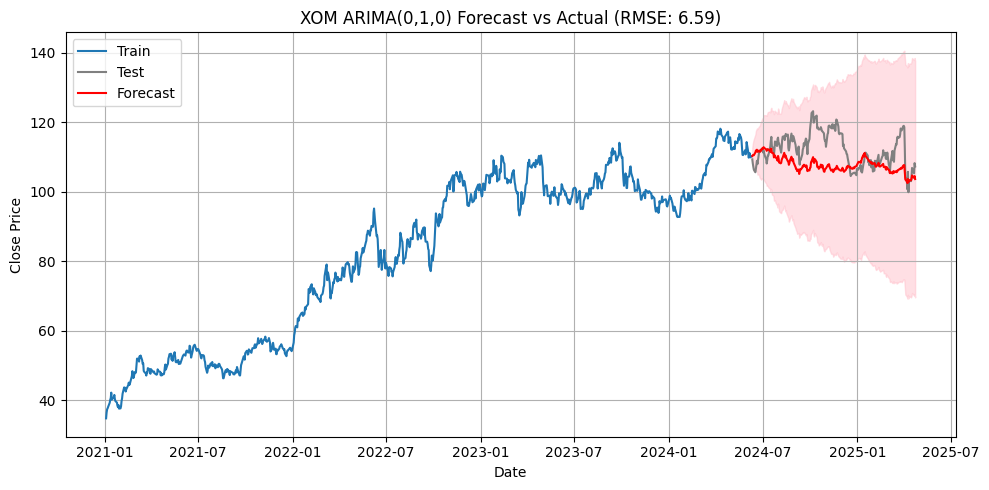

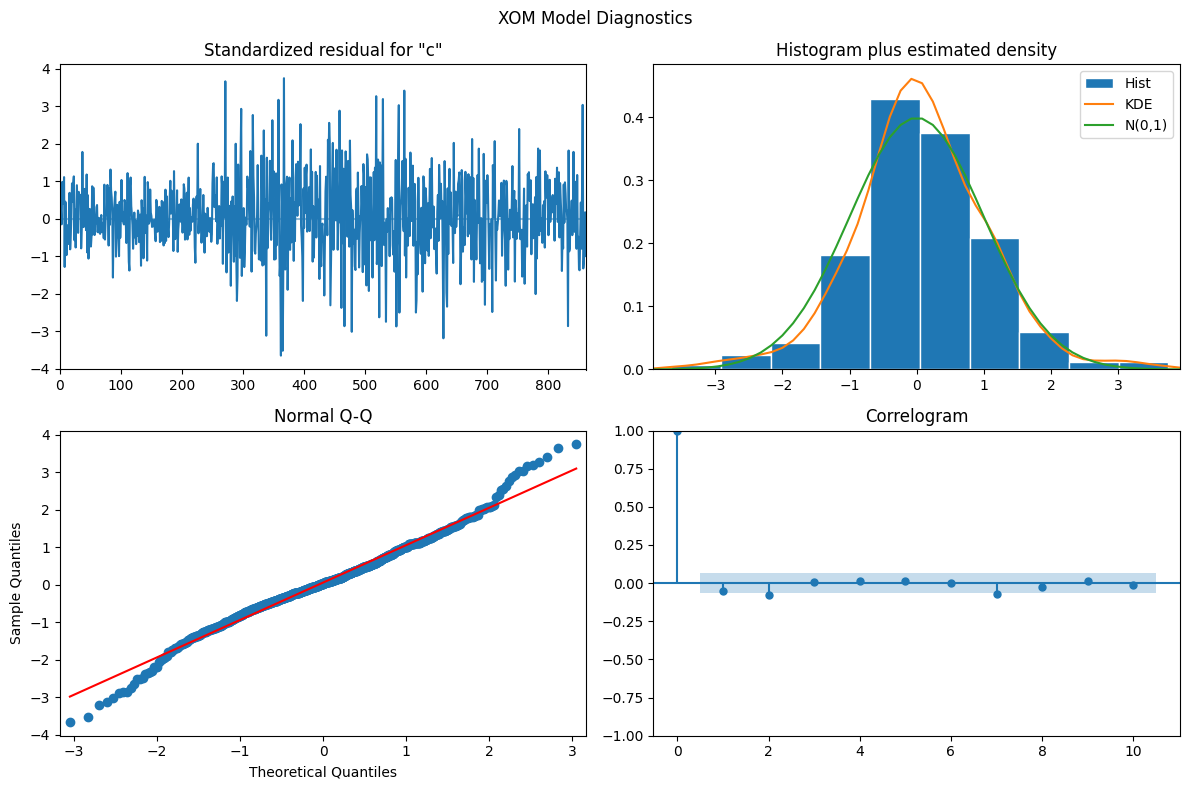

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


BP Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -507.983
Date:                Thu, 24 Apr 2025   AIC                           1019.966
Time:                        23:54:43   BIC                           1029.487
Sample:                             0   HQIC                          1023.610
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.1298      0.005     28.173      0.000       0.121       0.139
sigma2         0.1900      0.005     37.674      0.000       0.180       0.200
Ljung-Box (L1) (Q):              

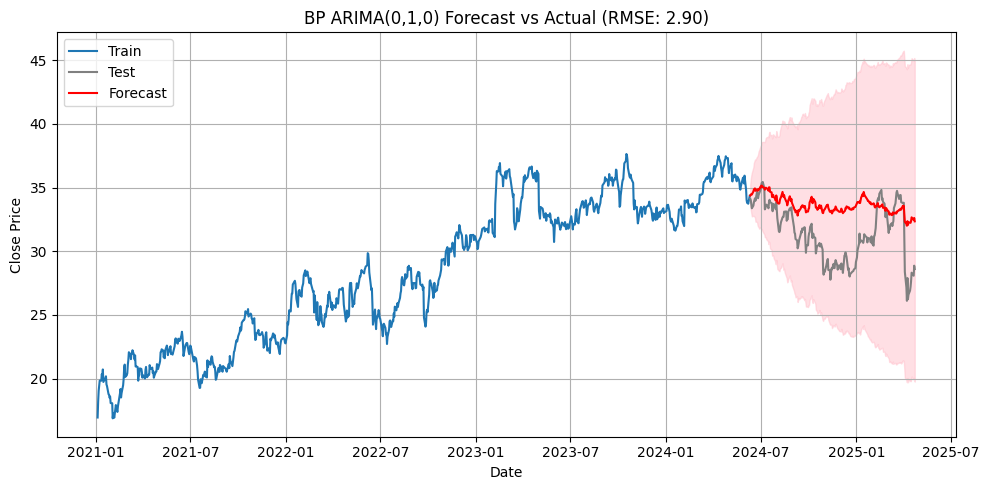

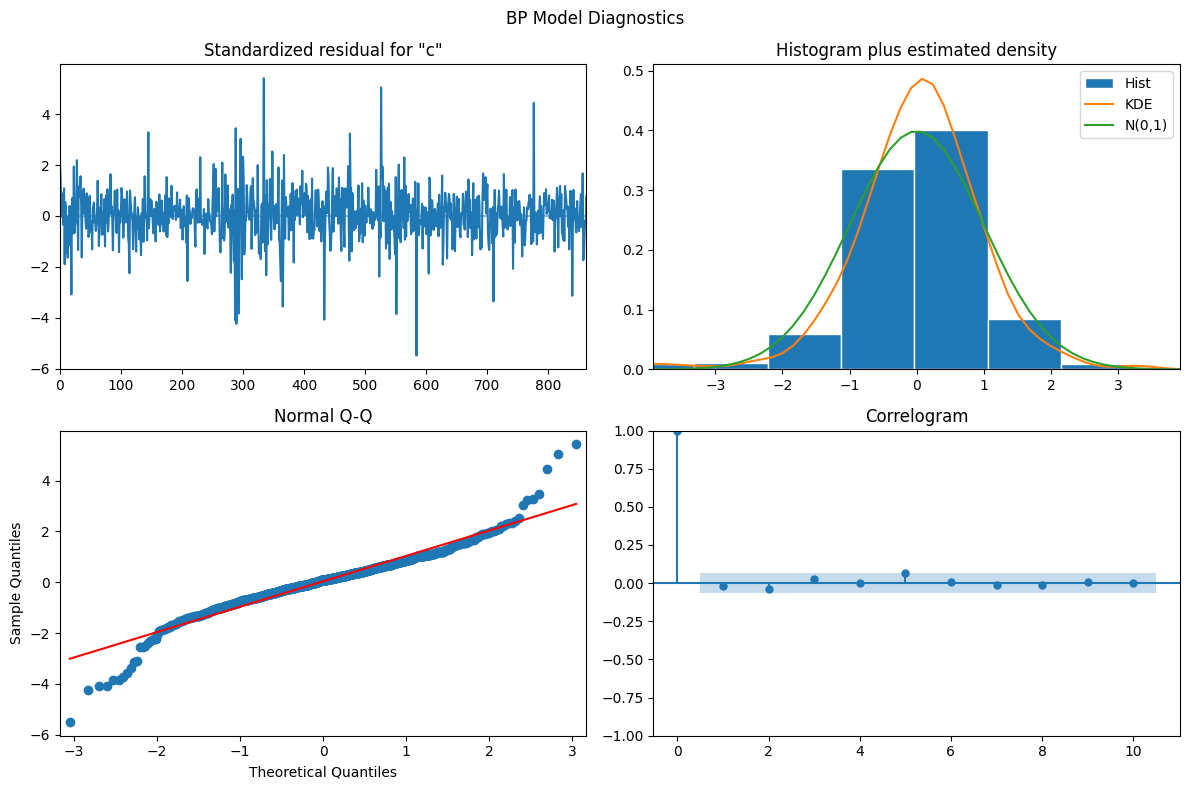

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


CVX Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1750.748
Date:                Thu, 24 Apr 2025   AIC                           3505.496
Time:                        23:54:44   BIC                           3515.016
Sample:                             0   HQIC                          3509.140
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.5803      0.022     26.491      0.000       0.537       0.623
sigma2         3.3855      0.089     37.849      0.000       3.210       3.561
Ljung-Box (L1) (Q):             

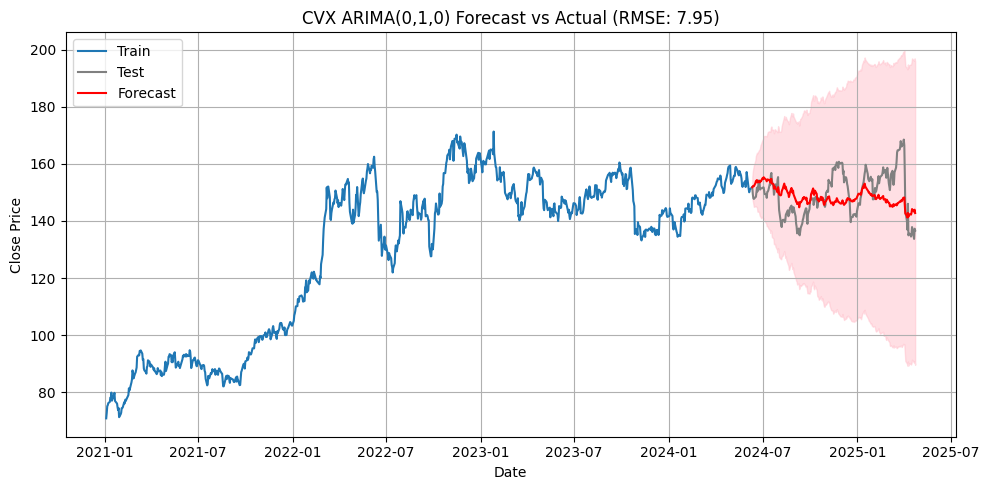

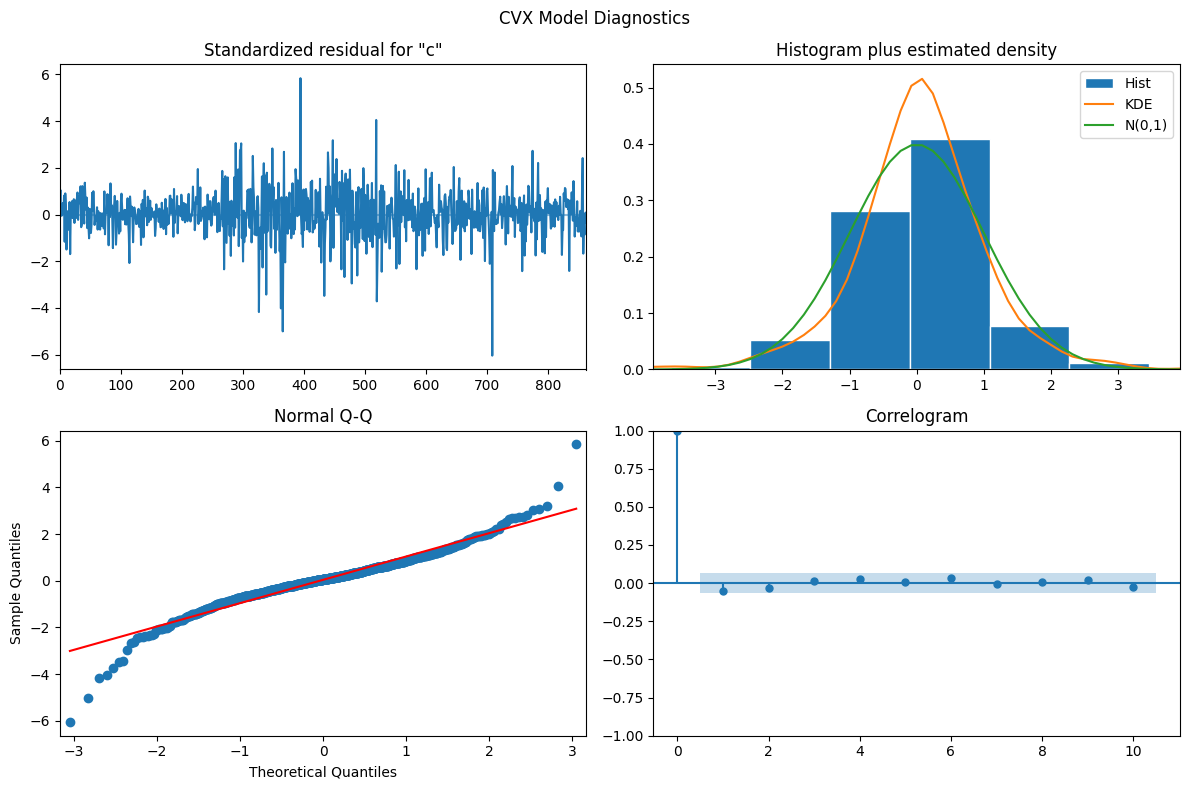

In [84]:
rmse_oil_dict =  {}

for ticker in tickers_names.keys():
    df = stock_data[stock_data['ticker'] == ticker]['close'].copy()
    
    # Train-test split (80% train, 20% test)
    split_idx = int(len(df) * 0.8)
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    
    # Fit ARIMA model on training data
    oil_df = stock_data[stock_data['ticker']=='CL=F']['close']
    # Reindex oil prices to match the current ticker's index
    oil_df = oil_df.reindex(df.index)
    oil_train = oil_df.iloc[:split_idx]
    oil_test = oil_df.iloc[split_idx:]
    model = ARIMA(train, order=(0, 1, 0), exog= oil_train)
    results = model.fit()
    print(f"\n{ticker} Model Summary:")
    print(results.summary())
    
    # Forecast for length of test set
    forecast = results.get_forecast(steps=len(test), exog=oil_test)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))
    rmse_oil_dict[ticker] = rmse
    print(f"{ticker} RMSE on test set: {rmse:.2f}")
    
    # Plot actual vs forecast
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='gray')
    plt.plot(test.index, forecast_mean, label='Forecast', color='red')
    plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
    plt.title(f"{ticker} ARIMA(0,1,0) Forecast vs Actual (RMSE: {rmse:.2f})")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/predictions/{ticker}_arima_model_with_crude_oil_price.png", dpi=300, bbox_inches='tight') 
    plt.show()
    
    # Plot diagnostics
    diag_fig = results.plot_diagnostics(figsize=(12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.savefig(f"plots/predictions/{ticker}_model_with_oil_diagnostics.png", dpi=300, bbox_inches='tight')
    plt.show()

In [85]:
print(rmse_dict)
print(rmse_oil_dict)

{'SHEL': np.float64(3.481308040809269), 'XOM': np.float64(5.158828741059415), 'BP': np.float64(3.6841205450198333), 'CVX': np.float64(7.96263788320132)}
{'SHEL': np.float64(2.672269970473439), 'XOM': np.float64(6.591386225318876), 'BP': np.float64(2.8961196088115346), 'CVX': np.float64(7.950206716451588)}


## Prediction with Natural Gas Data


SHEL Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1042.431
Date:                Thu, 24 Apr 2025   AIC                           2088.861
Time:                        23:54:46   BIC                           2098.382
Sample:                             0   HQIC                          2092.505
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.4676      0.107      4.365      0.000       0.258       0.678
sigma2         0.6557      0.024     27.309      0.000       0.609       0.703
Ljung-Box (L1) (Q):            

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

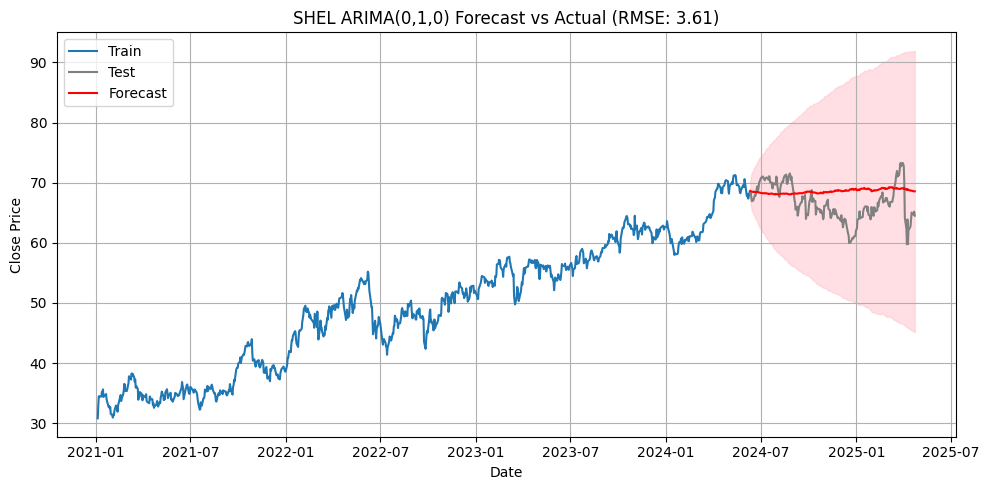

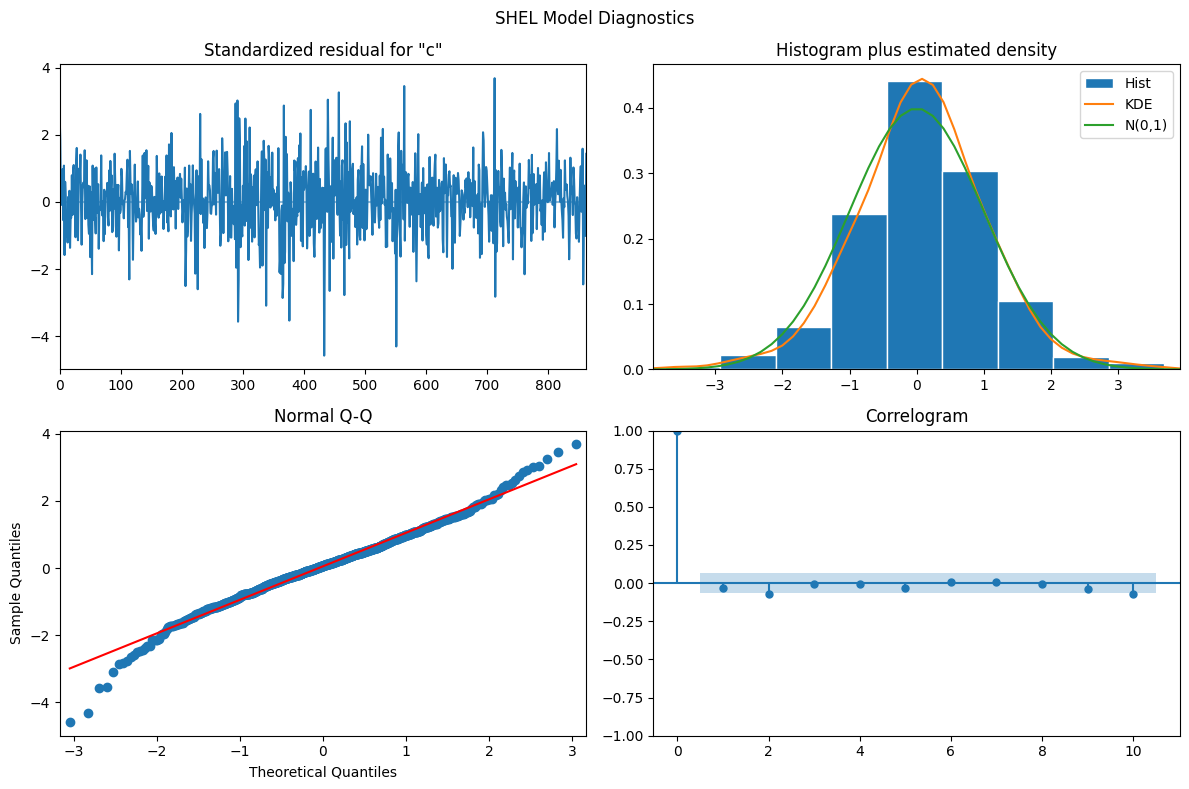

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


XOM Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1545.314
Date:                Thu, 24 Apr 2025   AIC                           3094.628
Time:                        23:54:48   BIC                           3104.149
Sample:                             0   HQIC                          3098.273
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          1.0344      0.177      5.854      0.000       0.688       1.381
sigma2         2.1031      0.081     25.993      0.000       1.944       2.262
Ljung-Box (L1) (Q):             

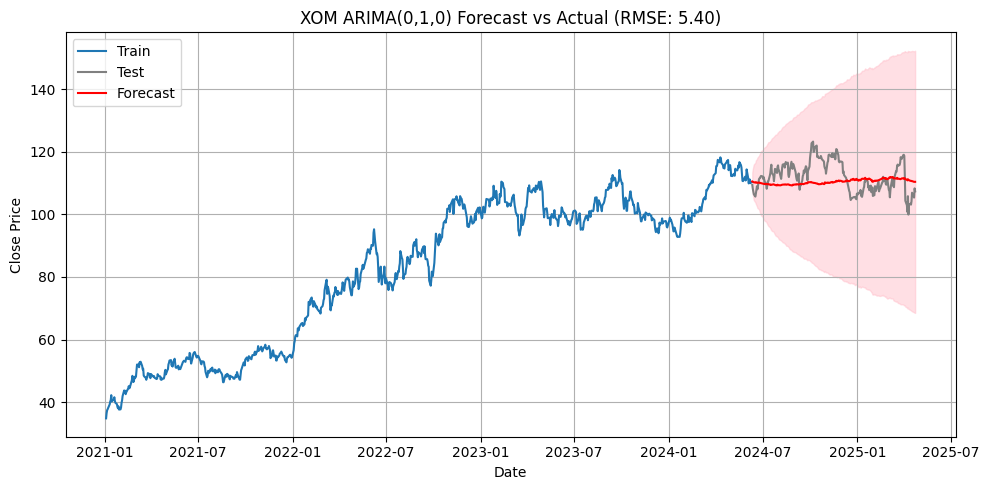

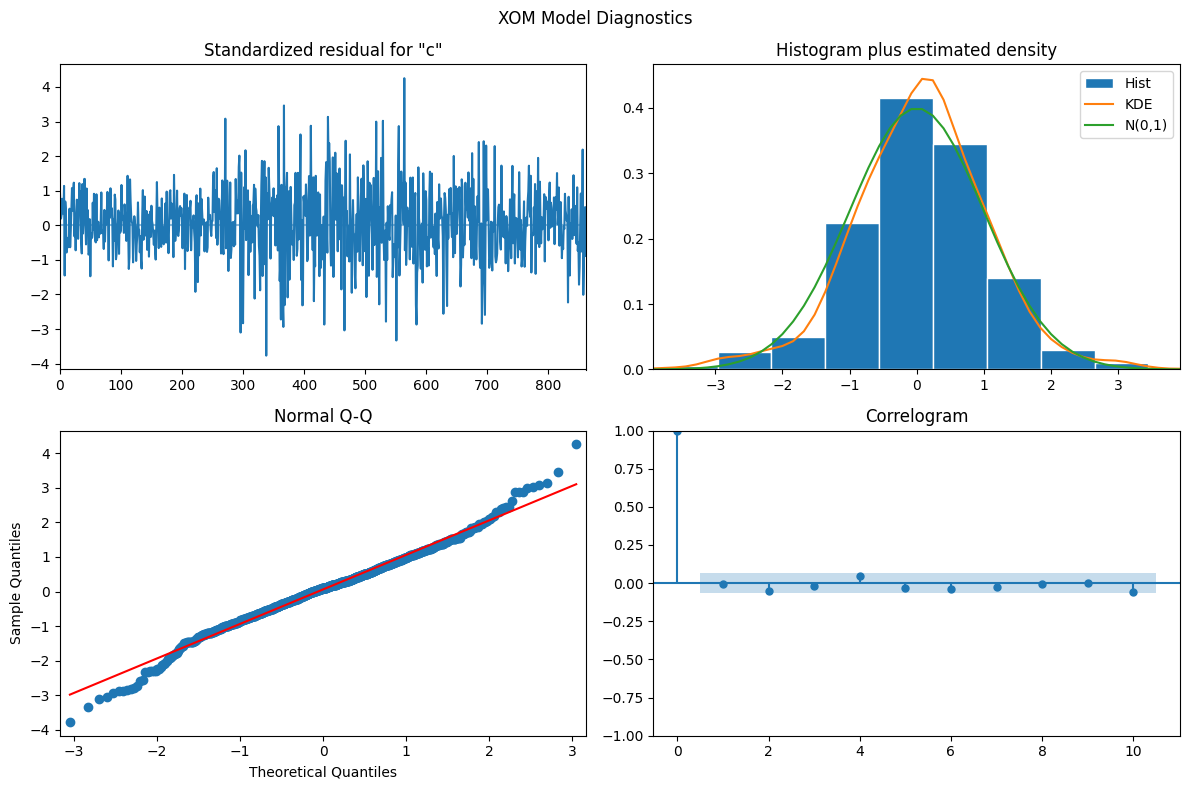

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


BP Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -639.454
Date:                Thu, 24 Apr 2025   AIC                           1282.908
Time:                        23:54:50   BIC                           1292.429
Sample:                             0   HQIC                          1286.552
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.2871      0.072      3.987      0.000       0.146       0.428
sigma2         0.2577      0.008     32.684      0.000       0.242       0.273
Ljung-Box (L1) (Q):              

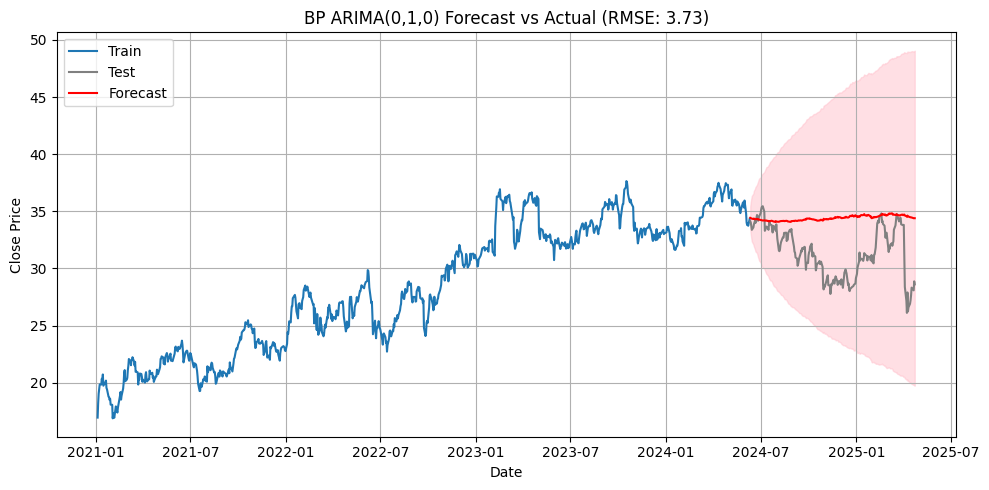

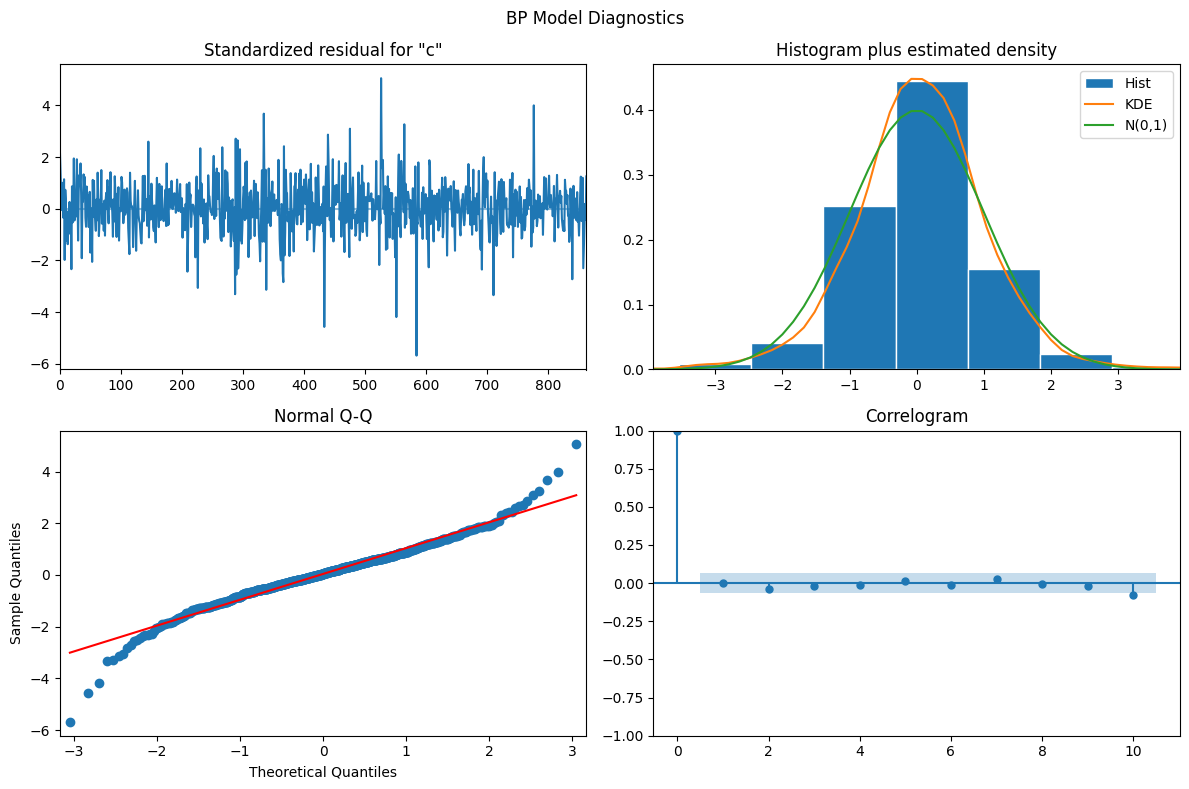

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


CVX Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  864
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1890.733
Date:                Thu, 24 Apr 2025   AIC                           3785.465
Time:                        23:54:52   BIC                           3794.986
Sample:                             0   HQIC                          3789.110
                                - 864                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          1.6109      0.264      6.093      0.000       1.093       2.129
sigma2         4.6828      0.144     32.483      0.000       4.400       4.965
Ljung-Box (L1) (Q):             

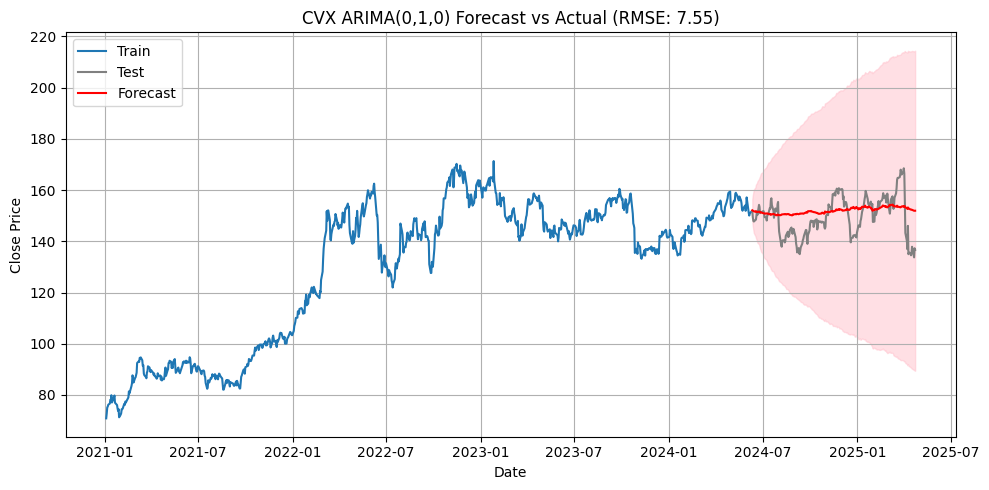

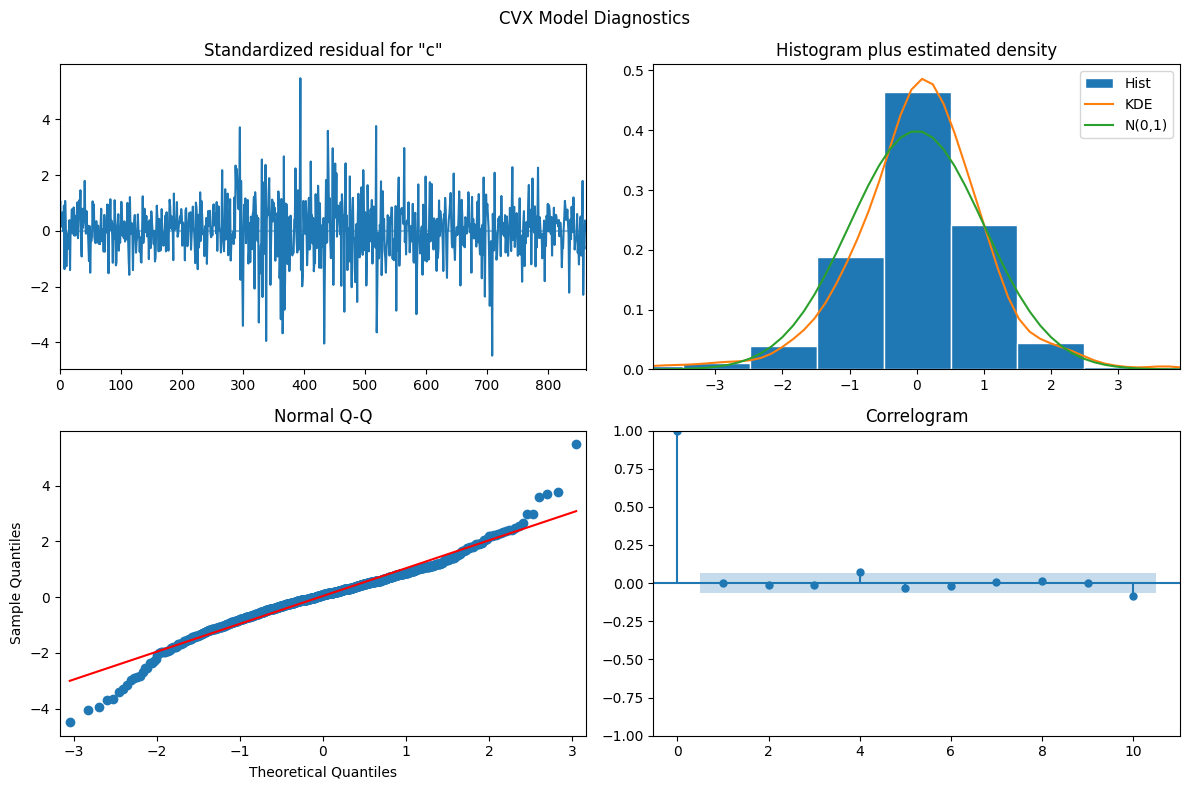

In [86]:
rmse_gas_dict = {}

for ticker in tickers_names.keys():
    df = stock_data[stock_data['ticker'] == ticker]['close'].copy()
    
    # Train-test split (80% train, 20% test)
    split_idx = int(len(df) * 0.8)
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    
    # Fit ARIMA model on training data
    oil_df = stock_data[stock_data['ticker']=='NG=F']['close']
    # Reindex oil prices to match the current ticker's index
    oil_df = oil_df.reindex(df.index)
    oil_train = oil_df.iloc[:split_idx]
    oil_test = oil_df.iloc[split_idx:]
    model = ARIMA(train, order=(0, 1, 0), exog= oil_train)
    results = model.fit()
    print(f"\n{ticker} Model Summary:")
    print(results.summary())
    
    # Forecast for length of test set
    forecast = results.get_forecast(steps=len(test), exog=oil_test)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))
    rmse_gas_dict[ticker] = rmse
    print(f"{ticker} RMSE on test set: {rmse:.2f}")
    
    # Plot actual vs forecast
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='gray')
    plt.plot(test.index, forecast_mean, label='Forecast', color='red')
    plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
    plt.title(f"{ticker} ARIMA(0,1,0) Forecast vs Actual (RMSE: {rmse:.2f})")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/predictions/{ticker}_arima_model_with_natural_gas_price.png", dpi=300, bbox_inches='tight') 
    plt.show()
    
    # Plot diagnostics
    diag_fig = results.plot_diagnostics(figsize=(12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.savefig(f"plots/predictions/{ticker}_model_with_gas_diagnostics.png", dpi=300, bbox_inches='tight')
    plt.show()

## Model Comparison

In [87]:
rmse_comparison_df = pd.DataFrame({
    'ARIMA': rmse_dict,
    'ARIMA + Crude Oil': rmse_oil_dict,
    'ARIMA + Natural Gas': rmse_gas_dict
})

rmse_comparison_df = rmse_comparison_df.round(3)
print(rmse_comparison_df)

      ARIMA  ARIMA + Crude Oil  ARIMA + Natural Gas
SHEL  3.481              2.672                3.612
XOM   5.159              6.591                5.405
BP    3.684              2.896                3.733
CVX   7.963              7.950                7.555
